# Бучин Вячеслав, 21.Б15-мм

## Задача

- [x] Найти данные размера хотя бы 10000, на которых можно решить задачу классификации или регрессии.
- [x] Выполнить разведочный анализ (**EDA**). При необходимости выполнить полезные преобразования данных.
- [x] Самостоятельно реализуйте алгоритмы **Bagging** и **AdaBoost**, которые позволят обучить ансамбли каких-то простых моделей, например деревьев принятия решений.
- [x] Обучите ансамбли для каких-то простых моделей, используя свои две реализации, а также реализации из **sklearn** (**Bagging**, **Random Forest**, **AdaBoost**, **Gradient Tree Boosting**, **Histogram-Based Gradient Boosting**).
- [x] При обучении использовать **подбор гиперпараметров**, **кросс-валидацию**.
- [x] Сравнить качество моделей: замерить скорость обучения, вычислить различные метрики качества, построить матрицы ошибок.
- [x] Также добавить в сравнение модели из библиотек **XGBoost**, **LightGBM** и **CatBoost**.
- [x] Для подбора гиперпараметров использовать фреймворк **Optuna**.

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pathlib

%matplotlib inline
%precision %.4f
warnings.filterwarnings('ignore') 

# Стоимость жилья
Подробное описание датасета: https://www.kaggle.com/datasets/anmolkumar/house-price-prediction-challenge?datasetId=902117

На этих данных предлагается решить задачу регрессии: предсказать стоимость жилья

In [11]:
data = pd.read_csv(pathlib.Path("dataset.csv"), encoding='unicode_escape')
data.shape

(29451, 12)

In [12]:
data.head()

,POSTED_BY,UNDER_CONSTRUCTION,RERA,BHK_NO.,BHK_OR_RK,SQUARE_FT,READY_TO_MOVE,RESALE,ADDRESS,LONGITUDE,LATITUDE,TARGET(PRICE_IN_LACS)
0,Owner,0,0,2,BHK,1300.236407,1,1,"Ksfc Layout,Bangalore",12.969910,77.597960,55.0
1,Dealer,0,0,2,BHK,1275.000000,1,1,"Vishweshwara Nagar,Mysore",12.274538,76.644605,51.0
2,Owner,0,0,2,BHK,933.159722,1,1,"Jigani,Bangalore",12.778033,77.632191,43.0
3,Owner,0,1,2,BHK,929.921143,1,1,"Sector-1 Vaishali,Ghaziabad",28.642300,77.344500,62.5
4,Dealer,1,0,2,BHK,999.009247,0,1,"New Town,Kolkata",22.592200,88.484911,60.5


In [13]:
data.describe()

,UNDER_CONSTRUCTION,RERA,BHK_NO.,SQUARE_FT,READY_TO_MOVE,RESALE,LONGITUDE,LATITUDE,TARGET(PRICE_IN_LACS)
count,29451.000000,29451.000000,29451.000000,2.945100e+04,29451.000000,29451.000000,29451.000000,29451.000000,29451.000000
mean,0.179756,0.317918,2.392279,1.980217e+04,0.820244,0.929578,21.300255,76.837695,142.898746
std,0.383991,0.465675,0.879091,1.901335e+06,0.383991,0.255861,6.205306,10.557747,656.880713
min,0.000000,0.000000,1.000000,3.000000e+00,0.000000,0.000000,-37.713008,-121.761248,0.250000
25%,0.000000,0.000000,2.000000,9.000211e+02,1.000000,1.000000,18.452663,73.798100,38.000000
50%,0.000000,0.000000,2.000000,1.175057e+03,1.000000,1.000000,20.750000,77.324137,62.000000
75%,0.000000,1.000000,3.000000,1.550688e+03,1.000000,1.000000,26.900926,77.828740,100.000000
max,1.000000,1.000000,20.000000,2.545455e+08,1.000000,1.000000,59.912884,152.962676,30000.000000


# EDA

In [14]:
data.isnull().sum()

POSTED_BY                0
UNDER_CONSTRUCTION       0
RERA                     0
BHK_NO.                  0
BHK_OR_RK                0
SQUARE_FT                0
READY_TO_MOVE            0
RESALE                   0
ADDRESS                  0
LONGITUDE                0
LATITUDE                 0
TARGET(PRICE_IN_LACS)    0
dtype: int64

In [15]:
data.duplicated().sum()

401

Датасет не содержит нулевых значений, но содержит дублирующиеся записи - удалим их

In [16]:
data = data.drop_duplicates()
data.duplicated().sum()

0

Переведем категориальные признаки в числовые

In [17]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

encoder.fit(data.POSTED_BY.drop_duplicates()) 
data.POSTED_BY = encoder.transform(data.POSTED_BY)

encoder.fit(data.BHK_OR_RK.drop_duplicates()) 
data.BHK_OR_RK = encoder.transform(data.BHK_OR_RK)

Ранжируем города в соответствии с https://en.wikipedia.org/wiki/Classification_of_Indian_cities

In [18]:
data["ADDRESS"] = data["ADDRESS"].str.split(',').apply(lambda x: x[-1])
data["ADDRESS"].value_counts(ascending=False).head(25)

ADDRESS
Bangalore        4272
Lalitpur         2963
Mumbai           2006
Pune             1980
Noida            1718
Kolkata          1686
Maharashtra      1571
Chennai          1245
Ghaziabad        1070
Jaipur            950
Chandigarh        660
Faridabad         625
Mohali            533
Vadodara          509
Gurgaon           419
Surat             419
Nagpur            331
Lucknow           321
Indore            301
Bhubaneswar       231
Bhopal            217
Kochi             205
Visakhapatnam     178
Bhiwadi           160
Goa               149
Name: count, dtype: int64

In [19]:
def map_city(city):
    if city in ['Ahmedabad', 'Bangalore', 'Chennai', 'Delhi', 'Hyderabad', 'Kolkata', 'Mumbai', 'Pune', 'Maharashtra']:
        return 1
    elif city in ['Agra', 'Ajmer', 'Aligarh', 'Amravati', 'Amritsar', 'Asansol', 'Aurangabad', 'Bareilly', 
                  'Belgaum', 'Bhavnagar', 'Bhiwandi', 'Bhopal', 'Bhubaneswar', 'Bikaner', 'Bilaspur', 'Bokaro Steel City', 
                  'Chandigarh', 'Coimbatore', 'Cuttack', 'Dehradun', 'Dhanbad', 'Bhilai', 'Durgapur', 'Dindigul', 'Erode', 
                  'Faridabad', 'Firozabad', 'Ghaziabad', 'Gorakhpur', 'Gulbarga', 'Guntur', 'Gwalior', 'Gurgaon', 'Guwahati', 
                  'Hamirpur', 'Hubli–Dharwad', 'Indore', 'Jabalpur', 'Jaipur', 'Jalandhar', 'Jammu', 'Jamnagar', 'Jamshedpur', 
                  'Jhansi', 'Jodhpur', 'Kakinada', 'Kannur', 'Kanpur', 'Karnal', 'Kochi', 'Kolhapur', 'Kollam', 'Kozhikode', 
                  'Kurnool', 'Ludhiana', 'Lucknow', 'Madurai', 'Malappuram', 'Mathura', 'Mangalore', 'Meerut', 'Moradabad', 
                  'Mysore', 'Nagpur', 'Nanded', 'Nashik', 'Nellore', 'Noida', 'Patna', 'Pondicherry', 'Purulia', 'Prayagraj', 
                  'Raipur', 'Rajkot', 'Rajahmundry', 'Ranchi', 'Rourkela', 'Ratlam', 'Salem', 'Sangli', 'Shimla', 'Siliguri', 
                  'Solapur', 'Srinagar', 'Surat', 'Thanjavur', 'Thiruvananthapuram', 'Thrissur', 'Tiruchirappalli', 'Tirunelveli', 
                  'Tiruvannamalai', 'Ujjain', 'Bijapur', 'Vadodara', 'Varanasi', 'Vasai-Virar City', 'Vijayawada', 'Visakhapatnam', 
                  'Vellore', 'Warangal']:
        return 2
    else:
        return 3
    
data['TIER'] = data['ADDRESS'].apply(map_city)
data = data.drop(columns = 'ADDRESS')

In [20]:
data["TARGET"] = data["TARGET(PRICE_IN_LACS)"]
data = data.drop(columns="TARGET(PRICE_IN_LACS)")
data.head()

,POSTED_BY,UNDER_CONSTRUCTION,RERA,BHK_NO.,BHK_OR_RK,SQUARE_FT,READY_TO_MOVE,RESALE,LONGITUDE,LATITUDE,TIER,TARGET
0,2,0,0,2,0,1300.236407,1,1,12.969910,77.597960,1,55.0
1,1,0,0,2,0,1275.000000,1,1,12.274538,76.644605,2,51.0
2,2,0,0,2,0,933.159722,1,1,12.778033,77.632191,1,43.0
3,2,0,1,2,0,929.921143,1,1,28.642300,77.344500,2,62.5
4,1,1,0,2,0,999.009247,0,1,22.592200,88.484911,1,60.5


<Axes: >

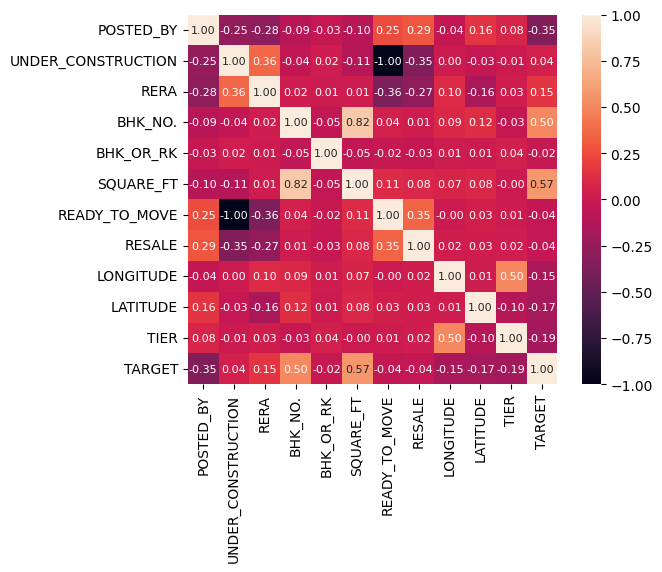

In [21]:
sns.heatmap(
    data.corr(method='spearman'),
    cbar=True,
    square=True,
    fmt='.2f',
    annot=True,
    annot_kws={'size':8},
)

Видна отрицательная корреляция между READY_TO_MOVE и UNDER_CONSTRUCTION, а также положительная корреляция между BHK_NO. и SQUARE_FT. Удалим UNDER_CONSTRUCTION и BHK_NO.

<Axes: >

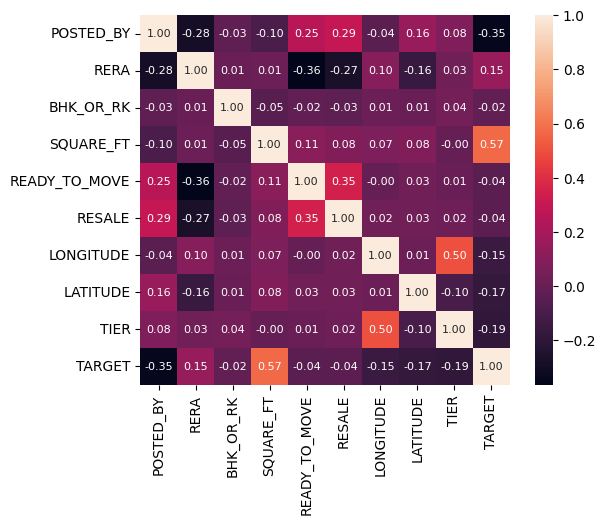

In [22]:
data = data.drop(columns=["UNDER_CONSTRUCTION", "BHK_NO."])
sns.heatmap(
    data.corr(method='spearman'),
    cbar=True,
    square=True,
    fmt='.2f',
    annot=True,
    annot_kws={'size':8},
)

# Информация о системе

In [23]:
!echo -e "\n\tOS:"
!uname --kernel-release
!echo -e "\n\tPython:"
!python --version
!echo -e "\n\tCPU:"
!lscpu | grep name
!echo -e "\n\tRAM:"
!free -g -h -t | grep Mem | cut -c1-23


	OS:
6.1.105-1-MANJARO

	Python:
Python 3.10.14

	CPU:
Model name:                           Intel(R) Core(TM) i7-6700K CPU @ 4.00GHz

	RAM:
Mem:            31Gi   


# Собственные реализации

In [57]:
from sklearn.base import BaseEstimator, RegressorMixin, clone
from sklearn.tree import DecisionTreeRegressor
from sklearn.utils.validation import check_X_y, check_scalar, check_random_state, check_is_fitted, check_array
from sklearn.utils.estimator_checks import check_estimator


class EnsembleRegressor(BaseEstimator, RegressorMixin):

    def __init__(self, estimator=None, n_estimators=10, random_state=None):
        self.estimator = estimator
        self.n_estimators = n_estimators
        self.random_state = random_state

    def _set_estimator_(self):
        self.estimator_ = self.estimator if self.estimator is not None else DecisionTreeRegressor() 

    def _set_random_states(self, estimator):
        states = {}
        for param in estimator.get_params(deep=True):
            if param == "random_state" or param.endswith("__random_state"):
                states[param] = self.random_state_.tomaxint() % 2 ** 32
        return states

    def _choose_data(self, X, y):
        indices = self.random_state_.choice(len(y), size=len(y))
        return X[indices], y[indices]
    
    def _new_estimator(self):
        estimator = clone(self.estimator_)
        estimator.set_params(**self._set_random_states(estimator))
        return estimator


class MyBaggingRegressor(EnsembleRegressor):


    def fit(self, X, y):
        self._set_estimator_()
        self.n_estimators = check_scalar(self.n_estimators, "n_estimators", int, min_val=1)
        self.random_state_ = check_random_state(self.random_state)
        X, y = check_X_y(X, y)

        self.n_features_in_ = X.shape[1]
        self.estimators_ = []

        for i in range(self.n_estimators):
            estimator = self._new_estimator()
            X_sample, y_sample = self._choose_data(X, y)
            estimator.fit(X_sample, y_sample)
            self.estimators_.append(estimator)

        return self

    def predict(self, X):
        check_is_fitted(self)
        X = check_array(X)

        predictions = [estimator.predict(X) for estimator in self.estimators_]

        return np.mean(predictions, axis=0)


class MyAdaBoostRegressor(EnsembleRegressor):

    def fit(self, X, y):
        self._set_estimator_()
        self.n_estimators = check_scalar(self.n_estimators, "n_estimators", int, min_val=1)
        self.random_state_ = check_random_state(self.random_state)
        X, y = check_X_y(X, y, y_numeric=True)
    
        self.n_features_in_ = X.shape[1]
        self.estimators_ = []
        self.weights_ = []

        sample_weight = np.full(len(y), fill_value=(1 / len(y)))

        for _ in range(self.n_estimators):
            estimator = self._new_estimator()
            predicted = estimator.fit(X, y, sample_weight=sample_weight).predict(X)

            errors = np.abs(predicted - y)
            max_error = np.max(errors)
            if max_error > 0:
                errors /= max_error
            avg_error = np.sum(errors * sample_weight)

            match avg_error:
                case 0: 
                    self.estimators_.append(estimator)
                    self.weights_.append(1.0)
                case x if x >= 0.5 and len(self.estimators_) == 0:
                    self.estimators_.append(estimator)
                    self.weights_.append(1.0)
                case _:
                    beta = avg_error / (1 - avg_error)
                    sample_weight *= np.power(beta, 1 - errors)
                    sample_weight /= np.sum(sample_weight)

                    self.estimators_.append(estimator)
                    self.weights_.append(np.log(1 / beta))

        self.weights_ = np.array(self.weights_)

        return self

    def predict(self, X):
        check_is_fitted(self)
        X = check_array(X)

        predictions = np.array([estimator.predict(X) for estimator in self.estimators_]).T

        sorted_prediction_ids = np.argsort(predictions, axis=1)
        sorted_weights_cumsum = np.cumsum(self.weights_[sorted_prediction_ids], axis=1)
        is_median_or_above = sorted_weights_cumsum >= (sorted_weights_cumsum[0][-1] / 2)

        median_ids = np.argmax(is_median_or_above, axis=1)
        median_ids = sorted_prediction_ids[np.arange(len(X)), median_ids]

        return predictions[np.arange(len(X)), median_ids]

check_estimator(MyBaggingRegressor())
check_estimator(MyAdaBoostRegressor())

# Обучение

In [32]:
X, Y = data.drop(columns="TARGET"), data.TARGET

In [33]:
MAGIC_NUMBER = 42 # used for random states
BRUTE_FORCE = 1000

In [75]:
import optuna
import os
import gc
from sklearn.model_selection import cross_validate, KFold


def fit(estimator, params_distribution):
    
    optuna.logging.set_verbosity(optuna.logging.WARNING)
    study = optuna.create_study(
        sampler=optuna.samplers.BruteForceSampler(BRUTE_FORCE), 
        direction="maximize",
    )
    
    search_model = optuna.integration.OptunaSearchCV(
        estimator,
        params_distribution,
        scoring="r2",
        n_jobs=3,
        n_trials=None,
        random_state=MAGIC_NUMBER,
        study=study,
    )
    
    results = cross_validate(
        search_model,
        X,
        Y,
        cv=KFold(shuffle=True, random_state=MAGIC_NUMBER),
        scoring=["r2", "neg_mean_absolute_error", "neg_mean_squared_error"],
        n_jobs=2,
    )

    return results


def add_to_comparsion(model_name, fitting_results, csv_path):
    results = pd.DataFrame(fitting_results).rename(
        columns={
            "estimator": "Model", 
            "fit_time": "Fit time, s", 
            "score_time": "Score time, s", 
            "test_r2": "R2"
        }
    )

    results["Model"] = model_name
    results["MAE"] = -results["test_neg_mean_absolute_error"]
    results["MSE"] = -results["test_neg_mean_squared_error"]
    results = results.drop(columns=["test_neg_mean_absolute_error", "test_neg_mean_squared_error"])
    
    results.to_csv(csv_path, mode="a", header=not csv_path.exists())


def add_model(name, estimator, params_distribution, models):
    models.append((name, fit(estimator, params_distribution)))


def add_all_to_comparsion(fitting_results, csv_path):
    if os.path.exists(csv_path):
      os.remove(csv_path)
    for (name, fitting_result) in fitting_results:
        add_to_comparsion(name, fitting_result, csv_path)


def show_comparsion(csv_path):
    cv_results = pd.read_csv(csv_path)

    img, axs = plt.subplots(ncols=5, figsize=(15, 5))

    for y, ax in zip(["Fit time, s", "Score time, s", "R2", "MAE", "MSE"], axs.flatten()):
        sns.barplot(cv_results[["Model", y]], x="Model", y=y, hue="Model", errwidth=1, capsize=0.3, ax=ax)
        ax.tick_params(axis="x", rotation=90)
        ax.set_xlabel(None)

    img.tight_layout()

    plt.show()

# Boosting

In [53]:
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, HistGradientBoostingRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
boosting_models = []

In [54]:
add_model(
    "GradientBoosting",
    GradientBoostingRegressor(random_state=MAGIC_NUMBER),
    {
        "n_estimators": optuna.distributions.CategoricalDistribution([50, 100, 200, 400]),
        "learning_rate": optuna.distributions.CategoricalDistribution([0.05, 0.1, 0.3]),
        "max_leaf_nodes": optuna.distributions.CategoricalDistribution([10, 1000, None]),
    },
    boosting_models
)

[I 2024-09-08 21:36:14,841] Trial 2 finished with value: 0.8737989846389536 and parameters: {'n_estimators': 50, 'learning_rate': 0.1, 'max_leaf_nodes': 10}. Best is trial 2 with value: 0.8737989846389536.
[I 2024-09-08 21:36:15,781] Trial 2 finished with value: 0.8837931971966431 and parameters: {'n_estimators': 50, 'learning_rate': 0.1, 'max_leaf_nodes': 10}. Best is trial 2 with value: 0.8837931971966431.
[I 2024-09-08 21:36:28,615] Trial 1 finished with value: 0.8946147452669031 and parameters: {'n_estimators': 200, 'learning_rate': 0.3, 'max_leaf_nodes': 10}. Best is trial 1 with value: 0.8946147452669031.
[I 2024-09-08 21:36:28,906] Trial 1 finished with value: 0.8872872513723318 and parameters: {'n_estimators': 200, 'learning_rate': 0.3, 'max_leaf_nodes': 10}. Best is trial 1 with value: 0.8872872513723318.
[I 2024-09-08 21:36:29,143] Trial 0 finished with value: 0.8919872633333601 and parameters: {'n_estimators': 200, 'learning_rate': 0.05, 'max_leaf_nodes': None}. Best is tria

In [56]:
add_model(
    "AdaBoost",
    AdaBoostRegressor(random_state=MAGIC_NUMBER),
    {
        "n_estimators": optuna.distributions.CategoricalDistribution([50, 100, 200, 400]),
        "learning_rate": optuna.distributions.CategoricalDistribution([0.5, 1, 2]),
    },
    boosting_models
)

[I 2024-09-08 21:47:33,286] Trial 1 finished with value: 0.8327860308877252 and parameters: {'n_estimators': 400, 'learning_rate': 1}. Best is trial 1 with value: 0.8327860308877252.
[I 2024-09-08 21:47:34,770] Trial 3 finished with value: 0.8327860308877252 and parameters: {'n_estimators': 50, 'learning_rate': 1}. Best is trial 1 with value: 0.8327860308877252.
[I 2024-09-08 21:47:35,330] Trial 2 finished with value: 0.831783082078922 and parameters: {'n_estimators': 400, 'learning_rate': 0.5}. Best is trial 1 with value: 0.8327860308877252.
[I 2024-09-08 21:47:35,421] Trial 0 finished with value: 0.831783082078922 and parameters: {'n_estimators': 200, 'learning_rate': 0.5}. Best is trial 1 with value: 0.8327860308877252.
[I 2024-09-08 21:47:35,478] Trial 1 finished with value: 0.6620761405797302 and parameters: {'n_estimators': 400, 'learning_rate': 1}. Best is trial 1 with value: 0.6620761405797302.
[I 2024-09-08 21:47:36,386] Trial 4 finished with value: -0.2074898277253904 and par

In [58]:
add_model(
    "MyAdaBoost",
    MyAdaBoostRegressor(random_state=MAGIC_NUMBER),
    {
        "n_estimators": optuna.distributions.CategoricalDistribution([50, 100, 200, 400]),
    },
    boosting_models
)

[I 2024-09-08 21:53:15,867] Trial 1 finished with value: 0.870930800758966 and parameters: {'n_estimators': 50}. Best is trial 1 with value: 0.870930800758966.
[I 2024-09-08 21:53:19,231] Trial 1 finished with value: 0.8699739146991419 and parameters: {'n_estimators': 50}. Best is trial 1 with value: 0.8699739146991419.
[I 2024-09-08 21:54:10,355] Trial 3 finished with value: 0.870930800758966 and parameters: {'n_estimators': 100}. Best is trial 1 with value: 0.870930800758966.
[I 2024-09-08 21:54:24,705] Trial 3 finished with value: 0.8699739146991419 and parameters: {'n_estimators': 100}. Best is trial 1 with value: 0.8699739146991419.
[I 2024-09-08 21:54:40,851] Trial 0 finished with value: 0.8699739146991419 and parameters: {'n_estimators': 200}. Best is trial 1 with value: 0.8699739146991419.
[I 2024-09-08 21:54:47,171] Trial 0 finished with value: 0.870930800758966 and parameters: {'n_estimators': 200}. Best is trial 1 with value: 0.870930800758966.
[I 2024-09-08 21:56:17,986] Tr

In [59]:
add_model(
    "HistGradientBoosting",
    HistGradientBoostingRegressor(random_state=MAGIC_NUMBER),
    {
        "learning_rate": optuna.distributions.CategoricalDistribution([0.05, 0.1, 0.3]),
        "max_leaf_nodes": optuna.distributions.CategoricalDistribution([15, 31, 60, None]),
    },
    boosting_models
)

[I 2024-09-08 22:04:09,578] Trial 2 finished with value: 0.7750106936273026 and parameters: {'learning_rate': 0.3, 'max_leaf_nodes': 15}. Best is trial 2 with value: 0.7750106936273026.
[I 2024-09-08 22:04:10,505] Trial 0 finished with value: 0.7723521880089613 and parameters: {'learning_rate': 0.1, 'max_leaf_nodes': 15}. Best is trial 2 with value: 0.7750106936273026.
[I 2024-09-08 22:04:10,726] Trial 1 finished with value: 0.8265947747085567 and parameters: {'learning_rate': 0.3, 'max_leaf_nodes': 15}. Best is trial 1 with value: 0.8265947747085567.
[I 2024-09-08 22:04:10,737] Trial 1 finished with value: 0.7772460699801993 and parameters: {'learning_rate': 0.3, 'max_leaf_nodes': 31}. Best is trial 1 with value: 0.7772460699801993.
[I 2024-09-08 22:04:13,158] Trial 0 finished with value: 0.8111339844055898 and parameters: {'learning_rate': 0.1, 'max_leaf_nodes': 15}. Best is trial 1 with value: 0.8265947747085567.
[I 2024-09-08 22:04:15,414] Trial 3 finished with value: 0.76974822581

In [60]:
add_model(
    "LGBMRegressor",
    LGBMRegressor(n_jobs=2, random_state=MAGIC_NUMBER),
    {
        "learning_rate": optuna.distributions.CategoricalDistribution([0.05, 0.1, 0.3]),
        "n_estimators": optuna.distributions.CategoricalDistribution([50, 100, 150]),
        "num_leaves": optuna.distributions.CategoricalDistribution([15, 31, 60]),
    },
    boosting_models
)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000849 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 140.805660
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000783 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 142.831173
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000919 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2024-09-08 22:09:51,426] Trial 2 finished with value: 0.7904313807152333 and parameters: {'learning_rate': 0.05, 'n_estimators': 100, 'num_leaves': 15}. Best is trial 2 with value: 0.7904313807152333.
[I 2024-09-08 22:09:51,439] Trial 0 finished with value: 0.8494531538857789 and parameters: {'learning_rate': 0.1, 'n_estimators': 50, 'num_leaves': 60}. Best is trial 0 with value: 0.8494531538857789.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000636 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 142.831173
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000755 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 134.584874
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000791 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2024-09-08 22:09:51,639] Trial 0 finished with value: 0.7782537882943121 and parameters: {'learning_rate': 0.1, 'n_estimators': 50, 'num_leaves': 60}. Best is trial 2 with value: 0.7904313807152333.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017793 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 141.913014
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000761 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 140.814874
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000762 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2024-09-08 22:09:51,961] Trial 1 finished with value: 0.8594464487467304 and parameters: {'learning_rate': 0.1, 'n_estimators': 150, 'num_leaves': 15}. Best is trial 1 with value: 0.8594464487467304.
[I 2024-09-08 22:09:52,057] Trial 2 finished with value: 0.850888134862368 and parameters: {'learning_rate': 0.05, 'n_estimators': 100, 'num_leaves': 15}. Best is trial 1 with value: 0.8594464487467304.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000686 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 142.703382
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005563 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 142.057490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000707 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2024-09-08 22:09:52,932] Trial 3 finished with value: 0.8479230037171407 and parameters: {'learning_rate': 0.1, 'n_estimators': 50, 'num_leaves': 31}. Best is trial 1 with value: 0.8594464487467304.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000718 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 142.057490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000718 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 134.584874


[I 2024-09-08 22:09:53,263] Trial 1 finished with value: 0.784864824468071 and parameters: {'learning_rate': 0.1, 'n_estimators': 150, 'num_leaves': 15}. Best is trial 2 with value: 0.7904313807152333.
[I 2024-09-08 22:09:53,374] Trial 3 finished with value: 0.7859783877984444 and parameters: {'learning_rate': 0.1, 'n_estimators': 50, 'num_leaves': 31}. Best is trial 2 with value: 0.7904313807152333.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009539 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 142.831173
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000753 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 141.913014
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002408 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bi

[I 2024-09-08 22:09:54,052] Trial 4 finished with value: 0.7800723553407188 and parameters: {'learning_rate': 0.05, 'n_estimators': 50, 'num_leaves': 60}. Best is trial 2 with value: 0.7904313807152333.
[I 2024-09-08 22:09:54,122] Trial 4 finished with value: 0.8335667965739659 and parameters: {'learning_rate': 0.05, 'n_estimators': 50, 'num_leaves': 60}. Best is trial 1 with value: 0.8594464487467304.
[I 2024-09-08 22:09:54,270] Trial 6 finished with value: 0.8516548335391386 and parameters: {'learning_rate': 0.3, 'n_estimators': 100, 'num_leaves': 15}. Best is trial 1 with value: 0.8594464487467304.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000717 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 140.805660
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.046984 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 140.814874
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000724 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2024-09-08 22:09:55,272] Trial 6 finished with value: 0.7678877601614861 and parameters: {'learning_rate': 0.3, 'n_estimators': 100, 'num_leaves': 15}. Best is trial 2 with value: 0.7904313807152333.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000797 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 142.057490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001102 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 140.814874
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.136645 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2024-09-08 22:09:56,070] Trial 8 finished with value: 0.8338745894643779 and parameters: {'learning_rate': 0.05, 'n_estimators': 50, 'num_leaves': 31}. Best is trial 1 with value: 0.8594464487467304.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000938 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 138.369585
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034743 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 140.805660
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001076 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2024-09-08 22:09:56,850] Trial 7 finished with value: 0.8573469243373493 and parameters: {'learning_rate': 0.3, 'n_estimators': 100, 'num_leaves': 60}. Best is trial 1 with value: 0.8594464487467304.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000754 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 134.584874
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000764 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 142.703382
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000754 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2024-09-08 22:09:57,500] Trial 5 finished with value: 0.8559084246116392 and parameters: {'learning_rate': 0.05, 'n_estimators': 150, 'num_leaves': 60}. Best is trial 1 with value: 0.8594464487467304.
[I 2024-09-08 22:09:57,600] Trial 8 finished with value: 0.7795838074248176 and parameters: {'learning_rate': 0.05, 'n_estimators': 50, 'num_leaves': 31}. Best is trial 2 with value: 0.7904313807152333.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000745 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 140.805660
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000903 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 140.814874
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000730 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2024-09-08 22:09:58,035] Trial 7 finished with value: 0.7665598263683708 and parameters: {'learning_rate': 0.3, 'n_estimators': 100, 'num_leaves': 60}. Best is trial 2 with value: 0.7904313807152333.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000776 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 142.831173
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000755 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 140.814874
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000750 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2024-09-08 22:09:58,999] Trial 10 finished with value: 0.8491714981408546 and parameters: {'learning_rate': 0.3, 'n_estimators': 150, 'num_leaves': 15}. Best is trial 1 with value: 0.8594464487467304.
[I 2024-09-08 22:09:59,098] Trial 5 finished with value: 0.7856865066768545 and parameters: {'learning_rate': 0.05, 'n_estimators': 150, 'num_leaves': 60}. Best is trial 2 with value: 0.7904313807152333.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000795 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 142.831173
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000834 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 141.913014
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000774 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2024-09-08 22:09:59,561] Trial 11 finished with value: 0.8508514165279848 and parameters: {'learning_rate': 0.05, 'n_estimators': 100, 'num_leaves': 31}. Best is trial 1 with value: 0.8594464487467304.
[I 2024-09-08 22:09:59,828] Trial 10 finished with value: 0.7573525158306773 and parameters: {'learning_rate': 0.3, 'n_estimators': 150, 'num_leaves': 15}. Best is trial 2 with value: 0.7904313807152333.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000709 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 134.584874
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000749 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 140.814874
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000680 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2024-09-08 22:10:00,764] Trial 9 finished with value: 0.8618133057187982 and parameters: {'learning_rate': 0.1, 'n_estimators': 150, 'num_leaves': 60}. Best is trial 9 with value: 0.8618133057187982.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000741 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 144.872495
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.084775 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 142.591883
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000713 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2024-09-08 22:10:01,091] Trial 12 finished with value: 0.8609355814248782 and parameters: {'learning_rate': 0.3, 'n_estimators': 100, 'num_leaves': 31}. Best is trial 9 with value: 0.8618133057187982.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000753 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 140.805660
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000724 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 142.703382
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001065 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2024-09-08 22:10:01,821] Trial 11 finished with value: 0.7805621626437986 and parameters: {'learning_rate': 0.05, 'n_estimators': 100, 'num_leaves': 31}. Best is trial 2 with value: 0.7904313807152333.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000746 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 142.831173
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000821 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 134.584874
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000864 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2024-09-08 22:10:02,283] Trial 12 finished with value: 0.7637006960964193 and parameters: {'learning_rate': 0.3, 'n_estimators': 100, 'num_leaves': 31}. Best is trial 2 with value: 0.7904313807152333.
[I 2024-09-08 22:10:02,355] Trial 9 finished with value: 0.7829791631233604 and parameters: {'learning_rate': 0.1, 'n_estimators': 150, 'num_leaves': 60}. Best is trial 2 with value: 0.7904313807152333.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000723 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000709 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 142.831173
[LightGBM] [Info] Start training from score 140.814874
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002465 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2024-09-08 22:10:02,610] Trial 13 finished with value: 0.8510826859216879 and parameters: {'learning_rate': 0.05, 'n_estimators': 100, 'num_leaves': 60}. Best is trial 9 with value: 0.8618133057187982.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000722 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 142.057490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000761 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 142.591883
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000667 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2024-09-08 22:10:04,604] Trial 14 finished with value: 0.854509359666838 and parameters: {'learning_rate': 0.3, 'n_estimators': 150, 'num_leaves': 31}. Best is trial 9 with value: 0.8618133057187982.


[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 140.805660
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000753 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 140.805660


[I 2024-09-08 22:10:04,823] Trial 15 finished with value: 0.8521352456372469 and parameters: {'learning_rate': 0.3, 'n_estimators': 150, 'num_leaves': 60}. Best is trial 9 with value: 0.8618133057187982.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030729 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 142.703382
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000674 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 134.584874
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000744 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2024-09-08 22:10:05,072] Trial 13 finished with value: 0.7861632704191619 and parameters: {'learning_rate': 0.05, 'n_estimators': 100, 'num_leaves': 60}. Best is trial 2 with value: 0.7904313807152333.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001378 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 141.913014
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000861 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 142.831173


[I 2024-09-08 22:10:05,414] Trial 14 finished with value: 0.7557121660176578 and parameters: {'learning_rate': 0.3, 'n_estimators': 150, 'num_leaves': 31}. Best is trial 2 with value: 0.7904313807152333.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001142 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 140.814874
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.043274 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 134.584874
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004622 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2024-09-08 22:10:05,879] Trial 16 finished with value: 0.8546416959372445 and parameters: {'learning_rate': 0.05, 'n_estimators': 150, 'num_leaves': 31}. Best is trial 9 with value: 0.8618133057187982.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000768 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 144.872495
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.044544 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 134.584874
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000698 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2024-09-08 22:10:06,901] Trial 18 finished with value: 0.8565326999846811 and parameters: {'learning_rate': 0.1, 'n_estimators': 100, 'num_leaves': 31}. Best is trial 9 with value: 0.8618133057187982.


[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 142.057490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.077703 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 140.805660
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000920 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 141.913014
[LightGBM] [Info] Auto-choosing row-wise 

[I 2024-09-08 22:10:07,139] Trial 17 finished with value: 0.786228838104953 and parameters: {'learning_rate': 0.05, 'n_estimators': 150, 'num_leaves': 15}. Best is trial 2 with value: 0.7904313807152333.
[I 2024-09-08 22:10:07,235] Trial 17 finished with value: 0.8546840356827186 and parameters: {'learning_rate': 0.05, 'n_estimators': 150, 'num_leaves': 15}. Best is trial 9 with value: 0.8618133057187982.


[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 142.591883
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000775 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 142.831173
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000671 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 140.805660


[I 2024-09-08 22:10:07,341] Trial 19 finished with value: 0.8359774342388894 and parameters: {'learning_rate': 0.05, 'n_estimators': 50, 'num_leaves': 15}. Best is trial 9 with value: 0.8618133057187982.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.109489 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000741 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 134.584874
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 140.805660
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000762 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2024-09-08 22:10:07,671] Trial 15 finished with value: 0.7589038423366254 and parameters: {'learning_rate': 0.3, 'n_estimators': 150, 'num_leaves': 60}. Best is trial 2 with value: 0.7904313807152333.


[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 144.872495
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000780 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 142.831173
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001345 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 140.814874
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead o

[I 2024-09-08 22:10:08,103] Trial 20 finished with value: 0.8495196381330306 and parameters: {'learning_rate': 0.1, 'n_estimators': 50, 'num_leaves': 15}. Best is trial 9 with value: 0.8618133057187982.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031940 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 134.584874
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000825 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 142.591883
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000718 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2024-09-08 22:10:08,786] Trial 19 finished with value: 0.7798033580389634 and parameters: {'learning_rate': 0.05, 'n_estimators': 50, 'num_leaves': 15}. Best is trial 2 with value: 0.7904313807152333.


[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 142.703382
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000828 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 138.369585


[I 2024-09-08 22:10:09,131] Trial 21 finished with value: 0.8555007270938934 and parameters: {'learning_rate': 0.1, 'n_estimators': 100, 'num_leaves': 15}. Best is trial 9 with value: 0.8618133057187982.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000761 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000705 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 140.805660
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 142.703382
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000705 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2024-09-08 22:10:09,575] Trial 18 finished with value: 0.7828162741200924 and parameters: {'learning_rate': 0.1, 'n_estimators': 100, 'num_leaves': 31}. Best is trial 2 with value: 0.7904313807152333.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007437 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 142.831173
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000621 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 142.057490


[I 2024-09-08 22:10:09,779] Trial 20 finished with value: 0.7863321929537849 and parameters: {'learning_rate': 0.1, 'n_estimators': 50, 'num_leaves': 15}. Best is trial 2 with value: 0.7904313807152333.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004411 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 138.369585
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000748 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 142.831173
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000775 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2024-09-08 22:10:10,023] Trial 16 finished with value: 0.7795134771028543 and parameters: {'learning_rate': 0.05, 'n_estimators': 150, 'num_leaves': 31}. Best is trial 2 with value: 0.7904313807152333.
[I 2024-09-08 22:10:10,157] Trial 24 finished with value: 0.8560724881322184 and parameters: {'learning_rate': 0.3, 'n_estimators': 50, 'num_leaves': 31}. Best is trial 9 with value: 0.8618133057187982.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013564 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 142.591883
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000737 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 141.913014
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000786 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2024-09-08 22:10:10,586] Trial 22 finished with value: 0.85993723016208 and parameters: {'learning_rate': 0.1, 'n_estimators': 150, 'num_leaves': 31}. Best is trial 9 with value: 0.8618133057187982.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000772 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 140.805660
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014181 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 134.584874
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001863 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bi

[I 2024-09-08 22:10:11,241] Trial 21 finished with value: 0.7890651714647678 and parameters: {'learning_rate': 0.1, 'n_estimators': 100, 'num_leaves': 15}. Best is trial 2 with value: 0.7904313807152333.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000792 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 142.057490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000737 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 140.814874
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000765 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2024-09-08 22:10:11,536] Trial 23 finished with value: 0.8581397487965863 and parameters: {'learning_rate': 0.1, 'n_estimators': 100, 'num_leaves': 60}. Best is trial 9 with value: 0.8618133057187982.
[I 2024-09-08 22:10:11,691] Trial 25 finished with value: 0.8573665430365752 and parameters: {'learning_rate': 0.3, 'n_estimators': 50, 'num_leaves': 60}. Best is trial 9 with value: 0.8618133057187982.
[I 2024-09-08 22:10:11,726] Trial 26 finished with value: 0.8520593684141531 and parameters: {'learning_rate': 0.3, 'n_estimators': 50, 'num_leaves': 15}. Best is trial 9 with value: 0.8618133057187982.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000713 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 138.369585
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000931 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 144.872495
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001060 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2024-09-08 22:10:12,168] Trial 24 finished with value: 0.7822268544876685 and parameters: {'learning_rate': 0.3, 'n_estimators': 50, 'num_leaves': 31}. Best is trial 2 with value: 0.7904313807152333.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001059 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.088751 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 144.437572
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 135.536700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005516 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bi

[I 2024-09-08 22:10:12,390] Trial 22 finished with value: 0.782468284259408 and parameters: {'learning_rate': 0.1, 'n_estimators': 150, 'num_leaves': 31}. Best is trial 2 with value: 0.7904313807152333.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000927 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000654 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 140.623983
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 138.369585
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000888 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2024-09-08 22:10:12,655] Trial 23 finished with value: 0.7848203864890377 and parameters: {'learning_rate': 0.1, 'n_estimators': 100, 'num_leaves': 60}. Best is trial 2 with value: 0.7904313807152333.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000827 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 142.591883
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020754 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 135.536700
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000736 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2024-09-08 22:10:13,135] Trial 26 finished with value: 0.7793402216202511 and parameters: {'learning_rate': 0.3, 'n_estimators': 50, 'num_leaves': 15}. Best is trial 2 with value: 0.7904313807152333.
[I 2024-09-08 22:10:13,198] Trial 2 finished with value: 0.8277600815281492 and parameters: {'learning_rate': 0.05, 'n_estimators': 100, 'num_leaves': 15}. Best is trial 2 with value: 0.8277600815281492.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000740 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 143.218364
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000767 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 143.218364
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000848 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2024-09-08 22:10:13,415] Trial 25 finished with value: 0.7753402347676419 and parameters: {'learning_rate': 0.3, 'n_estimators': 50, 'num_leaves': 60}. Best is trial 2 with value: 0.7904313807152333.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001108 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 142.576955
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000905 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 142.576955
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000798 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2024-09-08 22:10:13,774] Trial 1 finished with value: 0.8110817493214556 and parameters: {'learning_rate': 0.1, 'n_estimators': 150, 'num_leaves': 15}. Best is trial 2 with value: 0.8277600815281492.
[I 2024-09-08 22:10:13,933] Trial 3 finished with value: 0.8252810379476037 and parameters: {'learning_rate': 0.1, 'n_estimators': 50, 'num_leaves': 31}. Best is trial 2 with value: 0.8277600815281492.
[I 2024-09-08 22:10:13,956] Trial 0 finished with value: 0.8219776261631413 and parameters: {'learning_rate': 0.1, 'n_estimators': 50, 'num_leaves': 60}. Best is trial 2 with value: 0.8277600815281492.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030633 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 144.437572
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000778 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 144.437572
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000659 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2024-09-08 22:10:15,513] Trial 0 finished with value: 0.8130413210678749 and parameters: {'learning_rate': 0.1, 'n_estimators': 50, 'num_leaves': 60}. Best is trial 0 with value: 0.8130413210678749.
[I 2024-09-08 22:10:15,529] Trial 6 finished with value: 0.7853864118435138 and parameters: {'learning_rate': 0.3, 'n_estimators': 100, 'num_leaves': 15}. Best is trial 2 with value: 0.8277600815281492.
[I 2024-09-08 22:10:15,668] Trial 2 finished with value: 0.8030807899166854 and parameters: {'learning_rate': 0.05, 'n_estimators': 100, 'num_leaves': 15}. Best is trial 0 with value: 0.8130413210678749.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020875 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000762 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 147.670849
[LightGBM] [Info] Start training from score 138.715943


[I 2024-09-08 22:10:15,917] Trial 1 finished with value: 0.801399241781066 and parameters: {'learning_rate': 0.1, 'n_estimators': 150, 'num_leaves': 15}. Best is trial 0 with value: 0.8130413210678749.
[I 2024-09-08 22:10:15,964] Trial 4 finished with value: 0.8145137756053513 and parameters: {'learning_rate': 0.05, 'n_estimators': 50, 'num_leaves': 60}. Best is trial 2 with value: 0.8277600815281492.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000819 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 143.218364
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001019 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 147.670849
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.041776 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2024-09-08 22:10:16,884] Trial 3 finished with value: 0.8072219794336453 and parameters: {'learning_rate': 0.1, 'n_estimators': 50, 'num_leaves': 31}. Best is trial 0 with value: 0.8130413210678749.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000987 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 140.623983
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000841 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 143.218364
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001183 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2024-09-08 22:10:17,594] Trial 8 finished with value: 0.8151185699907524 and parameters: {'learning_rate': 0.05, 'n_estimators': 50, 'num_leaves': 31}. Best is trial 2 with value: 0.8277600815281492.
[I 2024-09-08 22:10:17,726] Trial 5 finished with value: 0.8189765593562696 and parameters: {'learning_rate': 0.05, 'n_estimators': 150, 'num_leaves': 60}. Best is trial 2 with value: 0.8277600815281492.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000737 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 145.771855
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000729 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 144.542446
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000669 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2024-09-08 22:10:17,916] Trial 7 finished with value: 0.7904942425231203 and parameters: {'learning_rate': 0.3, 'n_estimators': 100, 'num_leaves': 60}. Best is trial 2 with value: 0.8277600815281492.
[I 2024-09-08 22:10:18,078] Trial 4 finished with value: 0.8164602925417572 and parameters: {'learning_rate': 0.05, 'n_estimators': 50, 'num_leaves': 60}. Best is trial 4 with value: 0.8164602925417572.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000987 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 147.670849
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000887 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 135.536700
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.138425 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2024-09-08 22:10:18,610] Trial 6 finished with value: 0.7901903455795959 and parameters: {'learning_rate': 0.3, 'n_estimators': 100, 'num_leaves': 15}. Best is trial 4 with value: 0.8164602925417572.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000780 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 144.542446
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000779 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 147.670849
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000869 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2024-09-08 22:10:19,550] Trial 8 finished with value: 0.8176606802019737 and parameters: {'learning_rate': 0.05, 'n_estimators': 50, 'num_leaves': 31}. Best is trial 8 with value: 0.8176606802019737.
[I 2024-09-08 22:10:19,695] Trial 10 finished with value: 0.779225880977358 and parameters: {'learning_rate': 0.3, 'n_estimators': 150, 'num_leaves': 15}. Best is trial 2 with value: 0.8277600815281492.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007146 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000713 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 140.623983
[LightGBM] [Info] Start training from score 144.437572
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.081019 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2024-09-08 22:10:20,385] Trial 11 finished with value: 0.8270320501221636 and parameters: {'learning_rate': 0.05, 'n_estimators': 100, 'num_leaves': 31}. Best is trial 2 with value: 0.8277600815281492.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000865 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 144.437572
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000644 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 138.715943
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000839 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2024-09-08 22:10:20,797] Trial 5 finished with value: 0.8078762840387739 and parameters: {'learning_rate': 0.05, 'n_estimators': 150, 'num_leaves': 60}. Best is trial 8 with value: 0.8176606802019737.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000721 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 147.670849
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001009 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 140.623983
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000834 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2024-09-08 22:10:21,481] Trial 7 finished with value: 0.7862867515887061 and parameters: {'learning_rate': 0.3, 'n_estimators': 100, 'num_leaves': 60}. Best is trial 8 with value: 0.8176606802019737.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000728 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 140.623983
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000997 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 147.670849
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000715 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2024-09-08 22:10:21,988] Trial 12 finished with value: 0.7836160716354744 and parameters: {'learning_rate': 0.3, 'n_estimators': 100, 'num_leaves': 31}. Best is trial 2 with value: 0.8277600815281492.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000722 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 144.437572
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000863 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 141.128107
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000677 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2024-09-08 22:10:22,537] Trial 9 finished with value: 0.806076417975986 and parameters: {'learning_rate': 0.1, 'n_estimators': 150, 'num_leaves': 60}. Best is trial 2 with value: 0.8277600815281492.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000840 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 145.771855
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000750 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 141.128107
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000750 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2024-09-08 22:10:23,080] Trial 10 finished with value: 0.7917357750106535 and parameters: {'learning_rate': 0.3, 'n_estimators': 150, 'num_leaves': 15}. Best is trial 8 with value: 0.8176606802019737.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000655 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 144.542446
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000729 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 144.437572
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000618 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2024-09-08 22:10:23,305] Trial 13 finished with value: 0.8202702642322945 and parameters: {'learning_rate': 0.05, 'n_estimators': 100, 'num_leaves': 60}. Best is trial 2 with value: 0.8277600815281492.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000783 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 138.715943
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000753 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 135.536700
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013963 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2024-09-08 22:10:24,286] Trial 11 finished with value: 0.8089814661772786 and parameters: {'learning_rate': 0.05, 'n_estimators': 100, 'num_leaves': 31}. Best is trial 8 with value: 0.8176606802019737.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000808 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 145.771855
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000661 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 145.771855
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000643 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2024-09-08 22:10:25,177] Trial 9 finished with value: 0.8005903673297089 and parameters: {'learning_rate': 0.1, 'n_estimators': 150, 'num_leaves': 60}. Best is trial 8 with value: 0.8176606802019737.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000695 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 138.715943
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000735 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 147.670849
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000722 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2024-09-08 22:10:25,458] Trial 12 finished with value: 0.7945611224699798 and parameters: {'learning_rate': 0.3, 'n_estimators': 100, 'num_leaves': 31}. Best is trial 8 with value: 0.8176606802019737.
[I 2024-09-08 22:10:25,560] Trial 14 finished with value: 0.7719270318668853 and parameters: {'learning_rate': 0.3, 'n_estimators': 150, 'num_leaves': 31}. Best is trial 2 with value: 0.8277600815281492.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000765 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 141.128107
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000780 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 138.715943
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000740 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2024-09-08 22:10:26,663] Trial 15 finished with value: 0.7793717889105751 and parameters: {'learning_rate': 0.3, 'n_estimators': 150, 'num_leaves': 60}. Best is trial 2 with value: 0.8277600815281492.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000731 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 143.218364
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000742 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 144.437572
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000956 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2024-09-08 22:10:27,253] Trial 16 finished with value: 0.8234976382193999 and parameters: {'learning_rate': 0.05, 'n_estimators': 150, 'num_leaves': 31}. Best is trial 2 with value: 0.8277600815281492.
[I 2024-09-08 22:10:27,262] Trial 17 finished with value: 0.8233616036741214 and parameters: {'learning_rate': 0.05, 'n_estimators': 150, 'num_leaves': 15}. Best is trial 2 with value: 0.8277600815281492.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000729 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 135.536700
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000717 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 135.536700
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000908 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2024-09-08 22:10:27,803] Trial 13 finished with value: 0.8072484495044037 and parameters: {'learning_rate': 0.05, 'n_estimators': 100, 'num_leaves': 60}. Best is trial 8 with value: 0.8176606802019737.
[I 2024-09-08 22:10:27,893] Trial 20 finished with value: 0.8261035958035421 and parameters: {'learning_rate': 0.1, 'n_estimators': 50, 'num_leaves': 15}. Best is trial 2 with value: 0.8277600815281492.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000756 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 143.218364
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002331 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 144.437572
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000818 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2024-09-08 22:10:28,147] Trial 19 finished with value: 0.8180552657915031 and parameters: {'learning_rate': 0.05, 'n_estimators': 50, 'num_leaves': 15}. Best is trial 2 with value: 0.8277600815281492.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000871 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 144.437572
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000801 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 135.536700
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000739 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2024-09-08 22:10:28,368] Trial 14 finished with value: 0.7904387073530483 and parameters: {'learning_rate': 0.3, 'n_estimators': 150, 'num_leaves': 31}. Best is trial 8 with value: 0.8176606802019737.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000749 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 147.670849
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000857 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 138.715943
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000868 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2024-09-08 22:10:28,893] Trial 18 finished with value: 0.8157510166580826 and parameters: {'learning_rate': 0.1, 'n_estimators': 100, 'num_leaves': 31}. Best is trial 2 with value: 0.8277600815281492.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000706 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 143.218364
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000793 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 138.715943
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017507 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2024-09-08 22:10:29,552] Trial 21 finished with value: 0.816235759565884 and parameters: {'learning_rate': 0.1, 'n_estimators': 100, 'num_leaves': 15}. Best is trial 2 with value: 0.8277600815281492.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001005 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 144.437572
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000712 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 135.536700
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000640 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2024-09-08 22:10:29,820] Trial 15 finished with value: 0.7760712553259023 and parameters: {'learning_rate': 0.3, 'n_estimators': 150, 'num_leaves': 60}. Best is trial 8 with value: 0.8176606802019737.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000728 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 147.670849
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022641 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 144.542446
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000896 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2024-09-08 22:10:30,549] Trial 24 finished with value: 0.8029701997961952 and parameters: {'learning_rate': 0.3, 'n_estimators': 50, 'num_leaves': 31}. Best is trial 2 with value: 0.8277600815281492.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001081 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 144.437572
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000966 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 140.623983
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000814 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2024-09-08 22:10:30,863] Trial 17 finished with value: 0.8034097169628 and parameters: {'learning_rate': 0.05, 'n_estimators': 150, 'num_leaves': 15}. Best is trial 8 with value: 0.8176606802019737.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000670 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 138.715943
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000750 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 144.542446
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001757 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2024-09-08 22:10:31,194] Trial 16 finished with value: 0.8102243976838601 and parameters: {'learning_rate': 0.05, 'n_estimators': 150, 'num_leaves': 31}. Best is trial 8 with value: 0.8176606802019737.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000794 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 138.715943
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000915 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 143.218364
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000754 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2024-09-08 22:10:31,403] Trial 22 finished with value: 0.8089298192549847 and parameters: {'learning_rate': 0.1, 'n_estimators': 150, 'num_leaves': 31}. Best is trial 2 with value: 0.8277600815281492.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000746 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 144.542446
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001000 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 145.771855
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016541 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2024-09-08 22:10:31,749] Trial 20 finished with value: 0.808680320054761 and parameters: {'learning_rate': 0.1, 'n_estimators': 50, 'num_leaves': 15}. Best is trial 8 with value: 0.8176606802019737.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.168436 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000788 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Start training from score 135.536700
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 144.542446
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000810 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2024-09-08 22:10:32,138] Trial 19 finished with value: 0.8052898107674971 and parameters: {'learning_rate': 0.05, 'n_estimators': 50, 'num_leaves': 15}. Best is trial 8 with value: 0.8176606802019737.
[I 2024-09-08 22:10:32,218] Trial 23 finished with value: 0.8141291594223861 and parameters: {'learning_rate': 0.1, 'n_estimators': 100, 'num_leaves': 60}. Best is trial 2 with value: 0.8277600815281492.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000734 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 143.218364
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000729 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 142.576955
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001979 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2024-09-08 22:10:32,470] Trial 26 finished with value: 0.7990057000357416 and parameters: {'learning_rate': 0.3, 'n_estimators': 50, 'num_leaves': 15}. Best is trial 2 with value: 0.8277600815281492.
[I 2024-09-08 22:10:32,547] Trial 25 finished with value: 0.8061358344299349 and parameters: {'learning_rate': 0.3, 'n_estimators': 50, 'num_leaves': 60}. Best is trial 2 with value: 0.8277600815281492.
[I 2024-09-08 22:10:32,556] Trial 18 finished with value: 0.805122120978934 and parameters: {'learning_rate': 0.1, 'n_estimators': 100, 'num_leaves': 31}. Best is trial 8 with value: 0.8176606802019737.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001008 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 147.670849
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001301 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 144.542446
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000794 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2024-09-08 22:10:32,998] Trial 21 finished with value: 0.8056140873734157 and parameters: {'learning_rate': 0.1, 'n_estimators': 100, 'num_leaves': 15}. Best is trial 8 with value: 0.8176606802019737.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000813 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 147.670849
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001214 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 136.055468
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000806 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2024-09-08 22:10:34,058] Trial 24 finished with value: 0.8028338764989563 and parameters: {'learning_rate': 0.3, 'n_estimators': 50, 'num_leaves': 31}. Best is trial 8 with value: 0.8176606802019737.
[I 2024-09-08 22:10:34,245] Trial 1 finished with value: 0.7609499203172656 and parameters: {'learning_rate': 0.1, 'n_estimators': 150, 'num_leaves': 15}. Best is trial 1 with value: 0.7609499203172656.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018695 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 147.670849
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000629 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000874 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the t

[I 2024-09-08 22:10:34,541] Trial 22 finished with value: 0.8021335171275933 and parameters: {'learning_rate': 0.1, 'n_estimators': 150, 'num_leaves': 31}. Best is trial 8 with value: 0.8176606802019737.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005443 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 142.788747
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001139 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 147.670849
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000861 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2024-09-08 22:10:34,800] Trial 2 finished with value: 0.7818470331034986 and parameters: {'learning_rate': 0.05, 'n_estimators': 100, 'num_leaves': 15}. Best is trial 2 with value: 0.7818470331034986.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000743 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 141.128107
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000871 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 144.190226
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000778 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2024-09-08 22:10:35,354] Trial 26 finished with value: 0.7923042959334555 and parameters: {'learning_rate': 0.3, 'n_estimators': 50, 'num_leaves': 15}. Best is trial 8 with value: 0.8176606802019737.
[I 2024-09-08 22:10:35,410] Trial 0 finished with value: 0.7872577261096169 and parameters: {'learning_rate': 0.1, 'n_estimators': 50, 'num_leaves': 60}. Best is trial 0 with value: 0.7872577261096169.
[I 2024-09-08 22:10:35,436] Trial 25 finished with value: 0.7968879756348597 and parameters: {'learning_rate': 0.3, 'n_estimators': 50, 'num_leaves': 60}. Best is trial 8 with value: 0.8176606802019737.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000726 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 142.788747
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000757 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 144.542446
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000825 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2024-09-08 22:10:35,678] Trial 4 finished with value: 0.7878717454703729 and parameters: {'learning_rate': 0.05, 'n_estimators': 50, 'num_leaves': 60}. Best is trial 4 with value: 0.7878717454703729.
[I 2024-09-08 22:10:35,727] Trial 3 finished with value: 0.7853845531474366 and parameters: {'learning_rate': 0.1, 'n_estimators': 50, 'num_leaves': 31}. Best is trial 4 with value: 0.7878717454703729.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002756 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 136.055468
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000888 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 145.771855
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000820 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2024-09-08 22:10:36,186] Trial 23 finished with value: 0.8072134507546149 and parameters: {'learning_rate': 0.1, 'n_estimators': 100, 'num_leaves': 60}. Best is trial 8 with value: 0.8176606802019737.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004564 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 143.416853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000762 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 140.598421
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000743 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2024-09-08 22:10:36,439] Trial 6 finished with value: 0.7156310562357546 and parameters: {'learning_rate': 0.3, 'n_estimators': 100, 'num_leaves': 15}. Best is trial 4 with value: 0.7878717454703729.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000798 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 144.190226
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000805 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 143.416853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000752 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2024-09-08 22:10:36,910] Trial 8 finished with value: 0.7877078235227664 and parameters: {'learning_rate': 0.05, 'n_estimators': 50, 'num_leaves': 31}. Best is trial 4 with value: 0.7878717454703729.
[I 2024-09-08 22:10:36,984] Trial 7 finished with value: 0.7166288468514448 and parameters: {'learning_rate': 0.3, 'n_estimators': 100, 'num_leaves': 60}. Best is trial 4 with value: 0.7878717454703729.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000975 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 144.190226
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000864 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 142.788747
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000820 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2024-09-08 22:10:37,431] Trial 5 finished with value: 0.7735518903305815 and parameters: {'learning_rate': 0.05, 'n_estimators': 150, 'num_leaves': 60}. Best is trial 4 with value: 0.7878717454703729.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000771 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 142.788747
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000658 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 140.598421
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000928 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2024-09-08 22:10:37,707] Trial 10 finished with value: 0.6929004704936996 and parameters: {'learning_rate': 0.3, 'n_estimators': 150, 'num_leaves': 15}. Best is trial 4 with value: 0.7878717454703729.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000806 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 140.598421
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000817 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 136.055468
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000847 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2024-09-08 22:10:38,250] Trial 11 finished with value: 0.7869032202009482 and parameters: {'learning_rate': 0.05, 'n_estimators': 100, 'num_leaves': 31}. Best is trial 4 with value: 0.7878717454703729.
[I 2024-09-08 22:10:38,430] Trial 12 finished with value: 0.6913149405802725 and parameters: {'learning_rate': 0.3, 'n_estimators': 100, 'num_leaves': 31}. Best is trial 4 with value: 0.7878717454703729.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000769 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 144.190226
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001266 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 136.055468
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001569 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bi

[I 2024-09-08 22:10:38,557] Trial 9 finished with value: 0.7463216112000053 and parameters: {'learning_rate': 0.1, 'n_estimators': 150, 'num_leaves': 60}. Best is trial 4 with value: 0.7878717454703729.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001244 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 140.598421
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000895 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 140.598421
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000944 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bi

[I 2024-09-08 22:10:39,466] Trial 14 finished with value: 0.6740472864161577 and parameters: {'learning_rate': 0.3, 'n_estimators': 150, 'num_leaves': 31}. Best is trial 4 with value: 0.7878717454703729.
[I 2024-09-08 22:10:39,561] Trial 13 finished with value: 0.7863913693090504 and parameters: {'learning_rate': 0.05, 'n_estimators': 100, 'num_leaves': 60}. Best is trial 4 with value: 0.7878717454703729.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001279 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 144.190226
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000740 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 143.416853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000715 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bi

[I 2024-09-08 22:10:40,175] Trial 15 finished with value: 0.7004515949578456 and parameters: {'learning_rate': 0.3, 'n_estimators': 150, 'num_leaves': 60}. Best is trial 4 with value: 0.7878717454703729.
[I 2024-09-08 22:10:40,337] Trial 17 finished with value: 0.7770803058145994 and parameters: {'learning_rate': 0.05, 'n_estimators': 150, 'num_leaves': 15}. Best is trial 4 with value: 0.7878717454703729.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000817 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 142.788747
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001055 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 144.190226
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000780 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2024-09-08 22:10:40,657] Trial 19 finished with value: 0.7859008235731094 and parameters: {'learning_rate': 0.05, 'n_estimators': 50, 'num_leaves': 15}. Best is trial 4 with value: 0.7878717454703729.
[I 2024-09-08 22:10:40,704] Trial 16 finished with value: 0.7730177734712729 and parameters: {'learning_rate': 0.05, 'n_estimators': 150, 'num_leaves': 31}. Best is trial 4 with value: 0.7878717454703729.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000717 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 144.190226
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001984 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 143.416853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000804 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bi

[I 2024-09-08 22:10:40,968] Trial 20 finished with value: 0.7848348667096368 and parameters: {'learning_rate': 0.1, 'n_estimators': 50, 'num_leaves': 15}. Best is trial 4 with value: 0.7878717454703729.
[I 2024-09-08 22:10:41,015] Trial 18 finished with value: 0.7607536741713756 and parameters: {'learning_rate': 0.1, 'n_estimators': 100, 'num_leaves': 31}. Best is trial 4 with value: 0.7878717454703729.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000789 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 142.788747
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000709 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 136.055468
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000781 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2024-09-08 22:10:41,260] Trial 21 finished with value: 0.7748290545212184 and parameters: {'learning_rate': 0.1, 'n_estimators': 100, 'num_leaves': 15}. Best is trial 4 with value: 0.7878717454703729.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001844 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 140.598421
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000825 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 140.598421
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000994 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2024-09-08 22:10:41,802] Trial 24 finished with value: 0.7375696645346371 and parameters: {'learning_rate': 0.3, 'n_estimators': 50, 'num_leaves': 31}. Best is trial 4 with value: 0.7878717454703729.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000637 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 136.055468
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000761 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 142.788747
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000842 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2024-09-08 22:10:42,171] Trial 22 finished with value: 0.7471259451876808 and parameters: {'learning_rate': 0.1, 'n_estimators': 150, 'num_leaves': 31}. Best is trial 4 with value: 0.7878717454703729.
[I 2024-09-08 22:10:42,301] Trial 23 finished with value: 0.760433082017199 and parameters: {'learning_rate': 0.1, 'n_estimators': 100, 'num_leaves': 60}. Best is trial 4 with value: 0.7878717454703729.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000791 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 143.416853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000765 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 18592, number of used features: 8
[LightGBM] [Info] Start training from score 142.788747


[I 2024-09-08 22:10:42,384] Trial 25 finished with value: 0.7522491288310534 and parameters: {'learning_rate': 0.3, 'n_estimators': 50, 'num_leaves': 60}. Best is trial 4 with value: 0.7878717454703729.
[I 2024-09-08 22:10:42,470] Trial 26 finished with value: 0.7520567513214047 and parameters: {'learning_rate': 0.3, 'n_estimators': 50, 'num_leaves': 15}. Best is trial 4 with value: 0.7878717454703729.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001094 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 23240, number of used features: 8
[LightGBM] [Info] Start training from score 142.273704
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001094 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 23240, number of used features: 8
[LightGBM] [Info] Start training from score 143.565840
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001332 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

In [61]:
add_model(
    "CatBoost",
    CatBoostRegressor(thread_count=2, random_state=MAGIC_NUMBER),
    {
        "n_estimators": optuna.distributions.CategoricalDistribution([50, 100, 200, 400]),
    },
    boosting_models
)

Learning rate set to 0.240434
Learning rate set to 0.136854
Learning rate set to 0.5
0:	learn: 575.8954189	total: 49.7ms	remaining: 9.89s
1:	learn: 489.1761947	total: 52.9ms	remaining: 5.24s
2:	learn: 419.7349577	total: 55.8ms	remaining: 3.66s
3:	learn: 369.3543487	total: 59.7ms	remaining: 2.93s
4:	learn: 324.4934004	total: 61.9ms	remaining: 2.42s
0:	learn: 463.7978750	total: 61.3ms	remaining: 3s
5:	learn: 290.1425827	total: 64.2ms	remaining: 2.08s
6:	learn: 262.1603557	total: 66.5ms	remaining: 1.83s
1:	learn: 338.4760684	total: 66ms	remaining: 1.58s
7:	learn: 241.1656527	total: 68.9ms	remaining: 1.65s
0:	learn: 622.1299400	total: 67.1ms	remaining: 26.8s
8:	learn: 225.8055317	total: 71.1ms	remaining: 1.51s
2:	learn: 263.5523182	total: 71ms	remaining: 1.11s
9:	learn: 214.6091425	total: 73.6ms	remaining: 1.4s
3:	learn: 216.7644903	total: 73.7ms	remaining: 848ms
1:	learn: 567.0447910	total: 75.4ms	remaining: 15s
10:	learn: 202.1907573	total: 77.5ms	remaining: 1.33s
4:	learn: 197.4096942	t

[I 2024-09-08 22:19:36,734] Trial 1 finished with value: 0.8204986632627834 and parameters: {'n_estimators': 50}. Best is trial 1 with value: 0.8204986632627834.


111:	learn: 87.6101782	total: 385ms	remaining: 302ms
112:	learn: 87.3377083	total: 388ms	remaining: 299ms
307:	learn: 73.9708618	total: 1.4s	remaining: 418ms
Learning rate set to 0.5
308:	learn: 73.8726082	total: 1.4s	remaining: 413ms
113:	learn: 86.9459640	total: 395ms	remaining: 298ms
309:	learn: 73.8509488	total: 1.41s	remaining: 408ms
0:	learn: 451.0676895	total: 3.2ms	remaining: 157ms
310:	learn: 73.7942957	total: 1.41s	remaining: 403ms
114:	learn: 86.6545053	total: 402ms	remaining: 297ms
311:	learn: 73.7342804	total: 1.41s	remaining: 398ms
312:	learn: 73.6330756	total: 1.41s	remaining: 393ms
115:	learn: 86.2695031	total: 410ms	remaining: 297ms
313:	learn: 73.5677686	total: 1.42s	remaining: 388ms
116:	learn: 86.0657173	total: 412ms	remaining: 293ms
314:	learn: 73.4806337	total: 1.42s	remaining: 384ms
117:	learn: 85.7871859	total: 415ms	remaining: 288ms
315:	learn: 73.4459537	total: 1.43s	remaining: 379ms
118:	learn: 85.4884602	total: 419ms	remaining: 285ms
1:	learn: 329.3106522	to

[I 2024-09-08 22:19:37,085] Trial 1 finished with value: 0.7698063324141333 and parameters: {'n_estimators': 50}. Best is trial 1 with value: 0.7698063324141333.


69:	learn: 80.6268032	total: 264ms	remaining: 113ms
149:	learn: 81.4598067	total: 702ms	remaining: 234ms
386:	learn: 65.7163585	total: 1.76s	remaining: 59.1ms
150:	learn: 81.3081223	total: 706ms	remaining: 229ms
387:	learn: 65.6899545	total: 1.76s	remaining: 54.6ms
70:	learn: 80.5226812	total: 273ms	remaining: 111ms
151:	learn: 81.2136970	total: 711ms	remaining: 224ms
388:	learn: 65.6726074	total: 1.77s	remaining: 50ms
152:	learn: 81.0938854	total: 715ms	remaining: 220ms
389:	learn: 65.6338536	total: 1.77s	remaining: 45.5ms
71:	learn: 80.3109843	total: 281ms	remaining: 109ms
153:	learn: 80.9305002	total: 719ms	remaining: 215ms
390:	learn: 65.5932151	total: 1.78s	remaining: 40.9ms
154:	learn: 80.7799669	total: 722ms	remaining: 210ms
391:	learn: 65.5352731	total: 1.78s	remaining: 36.3ms
392:	learn: 65.5043880	total: 1.78s	remaining: 31.8ms
72:	learn: 80.0447344	total: 291ms	remaining: 107ms
155:	learn: 80.6775016	total: 729ms	remaining: 206ms
73:	learn: 79.8814046	total: 294ms	remaining:

[I 2024-09-08 22:19:39,410] Trial 3 finished with value: 0.8333959414224978 and parameters: {'n_estimators': 100}. Best is trial 3 with value: 0.8333959414224978.


97:	learn: 79.5583172	total: 429ms	remaining: 8.75ms
61:	learn: 126.9713690	total: 256ms	remaining: 1.39s
30:	learn: 120.4076322	total: 125ms	remaining: 682ms
62:	learn: 125.8398486	total: 258ms	remaining: 1.38s
98:	learn: 79.2971346	total: 433ms	remaining: 4.37ms
63:	learn: 124.9687423	total: 260ms	remaining: 1.37s
31:	learn: 118.9529476	total: 129ms	remaining: 679ms
99:	learn: 79.0260688	total: 435ms	remaining: 0us
64:	learn: 124.5896612	total: 263ms	remaining: 1.35s
65:	learn: 123.8705465	total: 266ms	remaining: 1.34s
32:	learn: 117.6741044	total: 135ms	remaining: 681ms
34:	learn: 115.5683825	total: 140ms	remaining: 662ms
68:	learn: 121.8706904	total: 272ms	remaining: 1.31s
69:	learn: 121.4972081	total: 276ms	remaining: 1.3s
35:	learn: 115.0483566	total: 152ms	remaining: 691ms
36:	learn: 114.4947822	total: 154ms	remaining: 678ms
70:	learn: 120.4444178	total: 283ms	remaining: 1.31s
37:	learn: 113.4686772	total: 156ms	remaining: 666ms
Learning rate set to 0.422409
71:	learn: 120.05233

[I 2024-09-08 22:19:39,868] Trial 3 finished with value: 0.7501131534166083 and parameters: {'n_estimators': 100}. Best is trial 1 with value: 0.7698063324141333.
[I 2024-09-08 22:19:39,988] Trial 0 finished with value: 0.7677889126341467 and parameters: {'n_estimators': 200}. Best is trial 1 with value: 0.7698063324141333.
[I 2024-09-08 22:19:40,040] Trial 0 finished with value: 0.8519719822481061 and parameters: {'n_estimators': 200}. Best is trial 0 with value: 0.8519719822481061.


140:	learn: 77.9075315	total: 516ms	remaining: 216ms
171:	learn: 93.2942436	total: 645ms	remaining: 855ms
141:	learn: 77.7479964	total: 521ms	remaining: 213ms
172:	learn: 93.0836735	total: 648ms	remaining: 850ms
80:	learn: 77.9971271	total: 365ms	remaining: 85.5ms
81:	learn: 77.7540800	total: 368ms	remaining: 80.7ms
142:	learn: 77.6527027	total: 525ms	remaining: 209ms
143:	learn: 77.4277731	total: 529ms	remaining: 206ms
173:	learn: 92.9365654	total: 656ms	remaining: 852ms
82:	learn: 77.4687332	total: 373ms	remaining: 76.5ms
144:	learn: 77.2910486	total: 532ms	remaining: 202ms
174:	learn: 92.7596403	total: 660ms	remaining: 848ms
83:	learn: 77.2939945	total: 376ms	remaining: 71.7ms
84:	learn: 77.0522037	total: 379ms	remaining: 66.9ms
175:	learn: 92.5512566	total: 663ms	remaining: 844ms
85:	learn: 76.8125219	total: 382ms	remaining: 62.2ms
145:	learn: 77.1765245	total: 539ms	remaining: 200ms
176:	learn: 92.4844652	total: 667ms	remaining: 841ms
146:	learn: 77.0731594	total: 544ms	remaining:

[I 2024-09-08 22:19:41,734] Trial 2 finished with value: 0.7781402142373591 and parameters: {'n_estimators': 400}. Best is trial 2 with value: 0.7781402142373591.
[I 2024-09-08 22:19:41,988] Trial 2 finished with value: 0.8281178479036223 and parameters: {'n_estimators': 400}. Best is trial 0 with value: 0.8519719822481061.


259:	learn: 74.6862399	total: 436ms	remaining: 235ms
260:	learn: 74.6267464	total: 438ms	remaining: 233ms
261:	learn: 74.5995453	total: 441ms	remaining: 232ms
262:	learn: 74.5484948	total: 443ms	remaining: 231ms
263:	learn: 74.4667468	total: 445ms	remaining: 229ms
264:	learn: 74.4268616	total: 446ms	remaining: 227ms
265:	learn: 74.3286453	total: 448ms	remaining: 226ms
266:	learn: 74.2683576	total: 450ms	remaining: 224ms
267:	learn: 74.2069678	total: 452ms	remaining: 223ms
268:	learn: 74.1054751	total: 454ms	remaining: 221ms
269:	learn: 74.0619546	total: 456ms	remaining: 219ms
270:	learn: 73.9674673	total: 458ms	remaining: 218ms
271:	learn: 73.8608450	total: 460ms	remaining: 216ms
272:	learn: 73.8066283	total: 462ms	remaining: 215ms
273:	learn: 73.7592158	total: 464ms	remaining: 213ms
274:	learn: 73.7151455	total: 466ms	remaining: 212ms
275:	learn: 73.6576540	total: 468ms	remaining: 210ms
276:	learn: 73.6208177	total: 471ms	remaining: 209ms
277:	learn: 73.5570557	total: 472ms	remaining:

[I 2024-09-08 22:19:43,909] Trial 1 finished with value: 0.766025441182966 and parameters: {'n_estimators': 50}. Best is trial 1 with value: 0.766025441182966.


67:	learn: 93.0204163	total: 308ms	remaining: 599ms
280:	learn: 82.1541597	total: 1.06s	remaining: 448ms
12:	learn: 131.7110587	total: 56.7ms	remaining: 161ms
13:	learn: 129.9815820	total: 59.9ms	remaining: 154ms
68:	learn: 92.7343780	total: 316ms	remaining: 600ms
14:	learn: 126.0267594	total: 61.8ms	remaining: 144ms
281:	learn: 82.0467091	total: 1.06s	remaining: 445ms
15:	learn: 124.1548910	total: 65ms	remaining: 138ms
69:	learn: 92.4256855	total: 322ms	remaining: 598ms
70:	learn: 92.2480577	total: 325ms	remaining: 590ms
16:	learn: 121.9375083	total: 70.8ms	remaining: 138ms
17:	learn: 120.6736902	total: 73.8ms	remaining: 131ms
71:	learn: 91.8421683	total: 328ms	remaining: 584ms
18:	learn: 119.9592699	total: 76.6ms	remaining: 125ms
72:	learn: 91.2340331	total: 332ms	remaining: 577ms
19:	learn: 118.4554402	total: 80.1ms	remaining: 120ms
282:	learn: 81.9955549	total: 1.08s	remaining: 448ms
73:	learn: 90.7047850	total: 336ms	remaining: 572ms
283:	learn: 81.9631200	total: 1.09s	remaining: 

[I 2024-09-08 22:19:44,610] Trial 1 finished with value: 0.7689503820896078 and parameters: {'n_estimators': 50}. Best is trial 1 with value: 0.7689503820896078.


66:	learn: 106.0431619	total: 284ms	remaining: 1.41s
28:	learn: 100.7583652	total: 157ms	remaining: 385ms
52:	learn: 107.8162946	total: 229ms	remaining: 634ms
29:	learn: 99.9525319	total: 162ms	remaining: 377ms
67:	learn: 105.7183751	total: 290ms	remaining: 1.42s
53:	learn: 107.1408374	total: 236ms	remaining: 638ms
30:	learn: 99.4683682	total: 165ms	remaining: 367ms
31:	learn: 97.9499660	total: 167ms	remaining: 356ms
32:	learn: 97.4329286	total: 170ms	remaining: 346ms
68:	learn: 105.3307983	total: 299ms	remaining: 1.44s
33:	learn: 96.7560907	total: 173ms	remaining: 335ms
54:	learn: 106.0042830	total: 245ms	remaining: 645ms
34:	learn: 96.0910045	total: 175ms	remaining: 325ms
69:	learn: 105.0666577	total: 304ms	remaining: 1.43s
35:	learn: 95.3212160	total: 178ms	remaining: 316ms
36:	learn: 94.5634878	total: 180ms	remaining: 307ms
70:	learn: 104.7626840	total: 308ms	remaining: 1.43s
55:	learn: 105.5336410	total: 253ms	remaining: 651ms
37:	learn: 93.7921906	total: 183ms	remaining: 298ms
38

[I 2024-09-08 22:19:46,391] Trial 3 finished with value: 0.7493892675433474 and parameters: {'n_estimators': 100}. Best is trial 1 with value: 0.766025441182966.


99:	learn: 82.9586806	total: 420ms	remaining: 0us
73:	learn: 104.9720156	total: 450ms	remaining: 766ms
281:	learn: 78.6899308	total: 1.28s	remaining: 537ms
74:	learn: 104.4922243	total: 456ms	remaining: 760ms
75:	learn: 104.3772922	total: 460ms	remaining: 751ms
282:	learn: 78.6357510	total: 1.29s	remaining: 535ms
76:	learn: 104.2382635	total: 463ms	remaining: 739ms
283:	learn: 78.3603282	total: 1.3s	remaining: 529ms
77:	learn: 103.4900329	total: 465ms	remaining: 728ms
284:	learn: 78.2554886	total: 1.3s	remaining: 524ms
78:	learn: 103.0081296	total: 468ms	remaining: 717ms
285:	learn: 78.1349334	total: 1.3s	remaining: 519ms
286:	learn: 78.0782855	total: 1.3s	remaining: 514ms
79:	learn: 102.7742334	total: 474ms	remaining: 711ms
287:	learn: 77.9651316	total: 1.31s	remaining: 508ms
84:	learn: 100.9855253	total: 491ms	remaining: 665ms
292:	learn: 77.5864819	total: 1.32s	remaining: 484ms
295:	learn: 77.2524920	total: 1.33s	remaining: 469ms
86:	learn: 100.2576477	total: 503ms	remaining: 654ms


[I 2024-09-08 22:19:46,920] Trial 0 finished with value: 0.7729466473539152 and parameters: {'n_estimators': 200}. Best is trial 0 with value: 0.7729466473539152.
[I 2024-09-08 22:19:47,078] Trial 3 finished with value: 0.7415431379340448 and parameters: {'n_estimators': 100}. Best is trial 1 with value: 0.7689503820896078.


178:	learn: 83.7030066	total: 996ms	remaining: 117ms
2:	learn: 290.1027615	total: 13.7ms	remaining: 442ms
179:	learn: 83.6359983	total: 1s	remaining: 111ms
180:	learn: 83.5647441	total: 1s	remaining: 105ms
Learning rate set to 0.136854
181:	learn: 83.4522117	total: 1.01s	remaining: 99.6ms
3:	learn: 242.1680866	total: 23.6ms	remaining: 567ms
182:	learn: 83.3911921	total: 1.01s	remaining: 93.8ms
183:	learn: 83.2985468	total: 1.01s	remaining: 88ms
4:	learn: 212.3315283	total: 29.1ms	remaining: 553ms
184:	learn: 83.1254381	total: 1.01s	remaining: 82.3ms
5:	learn: 188.3126611	total: 33.4ms	remaining: 524ms
0:	learn: 575.8373841	total: 9.91ms	remaining: 3.95s
185:	learn: 83.0810953	total: 1.02s	remaining: 76.7ms
186:	learn: 83.0097547	total: 1.02s	remaining: 71ms
187:	learn: 82.4130910	total: 1.02s	remaining: 65.4ms
6:	learn: 177.0609212	total: 40.2ms	remaining: 534ms
188:	learn: 82.2963000	total: 1.03s	remaining: 59.7ms
1:	learn: 520.6603968	total: 20.1ms	remaining: 4s
189:	learn: 82.244904

[I 2024-09-08 22:19:47,373] Trial 0 finished with value: 0.7719718006727113 and parameters: {'n_estimators': 200}. Best is trial 0 with value: 0.7719718006727113.


380:	learn: 70.6545215	total: 933ms	remaining: 46.5ms
381:	learn: 70.6336950	total: 935ms	remaining: 44.1ms
382:	learn: 70.5966385	total: 937ms	remaining: 41.6ms
383:	learn: 70.5270347	total: 939ms	remaining: 39.1ms
384:	learn: 70.4439163	total: 941ms	remaining: 36.7ms
385:	learn: 70.3302413	total: 943ms	remaining: 34.2ms
386:	learn: 70.2779421	total: 946ms	remaining: 31.8ms
387:	learn: 70.1977746	total: 948ms	remaining: 29.3ms
388:	learn: 70.1648967	total: 949ms	remaining: 26.8ms
389:	learn: 70.1415188	total: 951ms	remaining: 24.4ms
390:	learn: 70.1040503	total: 953ms	remaining: 21.9ms
391:	learn: 70.0715878	total: 955ms	remaining: 19.5ms
392:	learn: 70.0381988	total: 956ms	remaining: 17ms
393:	learn: 70.0058775	total: 959ms	remaining: 14.6ms
394:	learn: 69.9482662	total: 961ms	remaining: 12.2ms
395:	learn: 69.8976586	total: 962ms	remaining: 9.72ms
396:	learn: 69.8585957	total: 964ms	remaining: 7.29ms
397:	learn: 69.8186859	total: 966ms	remaining: 4.85ms
398:	learn: 69.7895774	total: 

[I 2024-09-08 22:19:48,912] Trial 2 finished with value: 0.7686124711319 and parameters: {'n_estimators': 400}. Best is trial 0 with value: 0.7729466473539152.


346:	learn: 69.5476847	total: 640ms	remaining: 97.7ms
347:	learn: 69.5119827	total: 642ms	remaining: 95.9ms
348:	learn: 69.4523477	total: 644ms	remaining: 94.1ms
349:	learn: 69.3728185	total: 645ms	remaining: 92.2ms
350:	learn: 69.3279901	total: 647ms	remaining: 90.3ms
351:	learn: 69.2558181	total: 648ms	remaining: 88.4ms
352:	learn: 69.1951365	total: 649ms	remaining: 86.5ms
353:	learn: 69.1507033	total: 651ms	remaining: 84.6ms
354:	learn: 69.1113324	total: 652ms	remaining: 82.7ms
355:	learn: 69.0683079	total: 653ms	remaining: 80.8ms
356:	learn: 68.9695766	total: 655ms	remaining: 78.9ms
357:	learn: 68.8972349	total: 657ms	remaining: 77ms
358:	learn: 68.8408587	total: 658ms	remaining: 75.2ms
359:	learn: 68.7556305	total: 660ms	remaining: 73.3ms
360:	learn: 68.7156549	total: 661ms	remaining: 71.4ms
361:	learn: 68.6604342	total: 663ms	remaining: 69.5ms
362:	learn: 68.6057310	total: 664ms	remaining: 67.7ms
363:	learn: 68.5367358	total: 665ms	remaining: 65.8ms
364:	learn: 68.4567188	total: 

[I 2024-09-08 22:19:49,259] Trial 2 finished with value: 0.7615831717585007 and parameters: {'n_estimators': 400}. Best is trial 0 with value: 0.7719718006727113.


99:	learn: 90.5776051	total: 215ms	remaining: 215ms
100:	learn: 90.2946780	total: 217ms	remaining: 213ms
101:	learn: 89.7904430	total: 219ms	remaining: 210ms
102:	learn: 89.5946282	total: 221ms	remaining: 208ms
103:	learn: 89.3151405	total: 223ms	remaining: 206ms
104:	learn: 88.8200531	total: 226ms	remaining: 204ms
105:	learn: 88.5167134	total: 228ms	remaining: 202ms
106:	learn: 88.4249609	total: 230ms	remaining: 200ms
107:	learn: 88.3034746	total: 232ms	remaining: 198ms
108:	learn: 88.0660834	total: 234ms	remaining: 195ms
109:	learn: 87.8916065	total: 237ms	remaining: 194ms
110:	learn: 87.8435664	total: 239ms	remaining: 192ms
111:	learn: 87.7360026	total: 241ms	remaining: 190ms
112:	learn: 87.6229993	total: 244ms	remaining: 188ms
113:	learn: 87.5552167	total: 246ms	remaining: 186ms
114:	learn: 87.3991723	total: 249ms	remaining: 184ms
115:	learn: 87.0253283	total: 251ms	remaining: 182ms
116:	learn: 86.7504673	total: 253ms	remaining: 180ms
117:	learn: 86.5397556	total: 255ms	remaining: 

[I 2024-09-08 22:19:50,345] Trial 1 finished with value: 0.7705094971532409 and parameters: {'n_estimators': 50}. Best is trial 1 with value: 0.7705094971532409.


16:	learn: 165.1336728	total: 34.5ms	remaining: 371ms
55:	learn: 83.8414525	total: 111ms	remaining: 87.4ms
15:	learn: 211.4877918	total: 35.7ms	remaining: 857ms
56:	learn: 83.3492309	total: 113ms	remaining: 85.3ms
17:	learn: 159.8823284	total: 36.9ms	remaining: 373ms
57:	learn: 82.8626004	total: 115ms	remaining: 83.2ms
16:	learn: 205.1644224	total: 38ms	remaining: 857ms
18:	learn: 156.8478078	total: 39.7ms	remaining: 378ms
58:	learn: 82.5619727	total: 117ms	remaining: 81.6ms
17:	learn: 199.9892004	total: 40.2ms	remaining: 853ms
19:	learn: 154.3503216	total: 42ms	remaining: 378ms
18:	learn: 194.2988359	total: 42.5ms	remaining: 851ms
59:	learn: 82.3550149	total: 120ms	remaining: 79.9ms
20:	learn: 150.5776053	total: 44.3ms	remaining: 378ms
19:	learn: 189.9249156	total: 44.6ms	remaining: 848ms
60:	learn: 82.1187356	total: 122ms	remaining: 78.1ms
21:	learn: 148.6635643	total: 46.8ms	remaining: 379ms
20:	learn: 187.3923486	total: 46.9ms	remaining: 846ms
61:	learn: 81.7697224	total: 125ms	rem

[I 2024-09-08 22:19:51,666] Trial 3 finished with value: 0.7678907469215319 and parameters: {'n_estimators': 100}. Best is trial 1 with value: 0.7705094971532409.
[I 2024-09-08 22:19:51,888] Trial 0 finished with value: 0.7708627750100749 and parameters: {'n_estimators': 200}. Best is trial 0 with value: 0.7708627750100749.


32:	learn: 100.3315744	total: 63.8ms	remaining: 129ms
33:	learn: 99.0961626	total: 66ms	remaining: 128ms
234:	learn: 80.0145288	total: 460ms	remaining: 323ms
Learning rate set to 0.422409
235:	learn: 79.9326744	total: 462ms	remaining: 321ms
35:	learn: 153.7824511	total: 79.3ms	remaining: 802ms
78:	learn: 82.4457201	total: 173ms	remaining: 46ms
36:	learn: 152.4691411	total: 81.1ms	remaining: 795ms
251:	learn: 77.2421142	total: 583ms	remaining: 343ms
252:	learn: 77.1808770	total: 586ms	remaining: 341ms
253:	learn: 77.0856025	total: 589ms	remaining: 338ms
254:	learn: 76.9655255	total: 591ms	remaining: 336ms
255:	learn: 76.8748075	total: 593ms	remaining: 334ms
256:	learn: 76.7666296	total: 596ms	remaining: 331ms
257:	learn: 76.6763053	total: 598ms	remaining: 329ms
258:	learn: 76.6115392	total: 600ms	remaining: 327ms
259:	learn: 76.5298125	total: 603ms	remaining: 325ms
260:	learn: 76.4627140	total: 605ms	remaining: 322ms
261:	learn: 76.3607350	total: 607ms	remaining: 320ms
262:	learn: 76.30

[I 2024-09-08 22:19:53,889] Trial 2 finished with value: 0.7838732808273325 and parameters: {'n_estimators': 400}. Best is trial 2 with value: 0.7838732808273325.


256:	learn: 78.0173045	total: 399ms	remaining: 222ms
257:	learn: 77.9562865	total: 401ms	remaining: 221ms
258:	learn: 77.9008104	total: 403ms	remaining: 219ms
259:	learn: 77.7633711	total: 405ms	remaining: 218ms
260:	learn: 77.7090123	total: 407ms	remaining: 217ms
261:	learn: 77.6405134	total: 409ms	remaining: 215ms
262:	learn: 77.5348749	total: 411ms	remaining: 214ms
263:	learn: 77.4863715	total: 413ms	remaining: 213ms
264:	learn: 77.4242655	total: 415ms	remaining: 211ms
265:	learn: 77.3442131	total: 417ms	remaining: 210ms
266:	learn: 77.2675362	total: 418ms	remaining: 208ms
267:	learn: 77.2108821	total: 420ms	remaining: 207ms
268:	learn: 77.1069088	total: 422ms	remaining: 206ms
269:	learn: 77.0754348	total: 424ms	remaining: 204ms
270:	learn: 76.9726691	total: 426ms	remaining: 203ms
271:	learn: 76.9130436	total: 428ms	remaining: 201ms
272:	learn: 76.8650017	total: 430ms	remaining: 200ms
273:	learn: 76.7970228	total: 432ms	remaining: 199ms
274:	learn: 76.7694543	total: 434ms	remaining:

In [67]:
add_model(
    "XGB",
    XGBRegressor(n_jobs=2, random_state=MAGIC_NUMBER),
    {
        "tree_method": optuna.distributions.CategoricalDistribution(["exact", "approx", "hist"]),
        "n_estimators": optuna.distributions.CategoricalDistribution([50, 100, 200, 400]),
        "learning_rate": optuna.distributions.CategoricalDistribution([0.05, 0.1, 0.3]),
    },
    boosting_models
)

[I 2024-09-08 22:42:45,938] Trial 0 finished with value: 0.8175952706994079 and parameters: {'tree_method': 'approx', 'n_estimators': 50, 'learning_rate': 0.3}. Best is trial 0 with value: 0.8175952706994079.
[I 2024-09-08 22:42:46,477] Trial 0 finished with value: 0.8252973259244172 and parameters: {'tree_method': 'approx', 'n_estimators': 50, 'learning_rate': 0.3}. Best is trial 0 with value: 0.8252973259244172.
[I 2024-09-08 22:42:47,918] Trial 3 finished with value: 0.8238037658807649 and parameters: {'tree_method': 'approx', 'n_estimators': 50, 'learning_rate': 0.1}. Best is trial 3 with value: 0.8238037658807649.
[I 2024-09-08 22:42:48,876] Trial 3 finished with value: 0.8443859138972337 and parameters: {'tree_method': 'approx', 'n_estimators': 50, 'learning_rate': 0.1}. Best is trial 3 with value: 0.8443859138972337.
[I 2024-09-08 22:42:51,372] Trial 2 finished with value: 0.8898405668092705 and parameters: {'tree_method': 'exact', 'n_estimators': 100, 'learning_rate': 0.05}. Be

# Bagging

In [68]:
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
bagging_models = []

In [69]:
add_model(
    "MyBagging",
    MyBaggingRegressor(random_state=MAGIC_NUMBER),
    {
        "n_estimators": optuna.distributions.CategoricalDistribution([50, 100, 200, 400]),    
    },
    bagging_models
)

[I 2024-09-08 22:49:34,007] Trial 1 finished with value: 0.8776481928595852 and parameters: {'n_estimators': 50}. Best is trial 1 with value: 0.8776481928595852.
[I 2024-09-08 22:49:34,298] Trial 1 finished with value: 0.8774455868268058 and parameters: {'n_estimators': 50}. Best is trial 1 with value: 0.8774455868268058.
[I 2024-09-08 22:50:22,323] Trial 3 finished with value: 0.8790346137558283 and parameters: {'n_estimators': 100}. Best is trial 3 with value: 0.8790346137558283.
[I 2024-09-08 22:50:25,925] Trial 3 finished with value: 0.8774626646063111 and parameters: {'n_estimators': 100}. Best is trial 3 with value: 0.8774626646063111.
[I 2024-09-08 22:50:39,631] Trial 0 finished with value: 0.880932356790798 and parameters: {'n_estimators': 200}. Best is trial 0 with value: 0.880932356790798.
[I 2024-09-08 22:50:41,810] Trial 0 finished with value: 0.8768548546970134 and parameters: {'n_estimators': 200}. Best is trial 3 with value: 0.8774626646063111.
[I 2024-09-08 22:51:58,710

In [70]:
add_model(
    "Bagging",
    BaggingRegressor(n_jobs=2, random_state=MAGIC_NUMBER),
    {
        "n_estimators": optuna.distributions.CategoricalDistribution([50, 100, 200, 400]),    
    },
    bagging_models
)

/home/chez/sources/spbu/ml/venv/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[I 2024-09-08 23:00:27,085] Trial 0 finished with value: 0.8803770202340978 and parameters: {'n_estimators': 200}. Best is trial 0 with value: 0.8803770202340978.
[I 2024-09-08 23:00:32,150] Trial 0 finished with value: 0.8766411842240794 and parameters: {'n_estimators': 200}. Best is trial 0 with value: 0.8766411842240794.
[I 2024-09-08 23:00:43,994] Trial 1 finished with value: 0.8814106526172573 and parameters: {'n_estimators': 50}. Best is trial 1 with value: 0.8814106526172573.
[I 2024-09-08 23:00:45,380] Trial 2 finished with value: 0.8812136463337614 and parameters: {'n_estimators': 400}. Best is trial 1 with value: 0.8814106526172573.
/home/chez/sources/spbu/ml/venv/lib/python3.10/site-packages/joblib/externals/lo

In [71]:
add_model(
    "RandomForest",
    RandomForestRegressor(n_jobs=2,random_state=MAGIC_NUMBER),
    {
        "n_estimators": optuna.distributions.CategoricalDistribution([50, 100, 200, 400]),
        "max_leaf_nodes": optuna.distributions.CategoricalDistribution([10, 1000, None]),
    },
    bagging_models
)

[I 2024-09-08 23:11:22,101] Trial 0 finished with value: 0.8551933814869248 and parameters: {'n_estimators': 200, 'max_leaf_nodes': 10}. Best is trial 0 with value: 0.8551933814869248.
[I 2024-09-08 23:11:24,335] Trial 0 finished with value: 0.8515581271987067 and parameters: {'n_estimators': 200, 'max_leaf_nodes': 10}. Best is trial 0 with value: 0.8515581271987067.
[I 2024-09-08 23:11:33,241] Trial 3 finished with value: 0.8731306557111118 and parameters: {'n_estimators': 50, 'max_leaf_nodes': 1000}. Best is trial 3 with value: 0.8731306557111118.
[I 2024-09-08 23:11:35,687] Trial 3 finished with value: 0.8809765996736498 and parameters: {'n_estimators': 50, 'max_leaf_nodes': 1000}. Best is trial 3 with value: 0.8809765996736498.
[I 2024-09-08 23:11:38,255] Trial 2 finished with value: 0.854719928542617 and parameters: {'n_estimators': 400, 'max_leaf_nodes': 10}. Best is trial 3 with value: 0.8731306557111118.
[I 2024-09-08 23:11:42,335] Trial 2 finished with value: 0.853237066868494

# Сравнение результатов

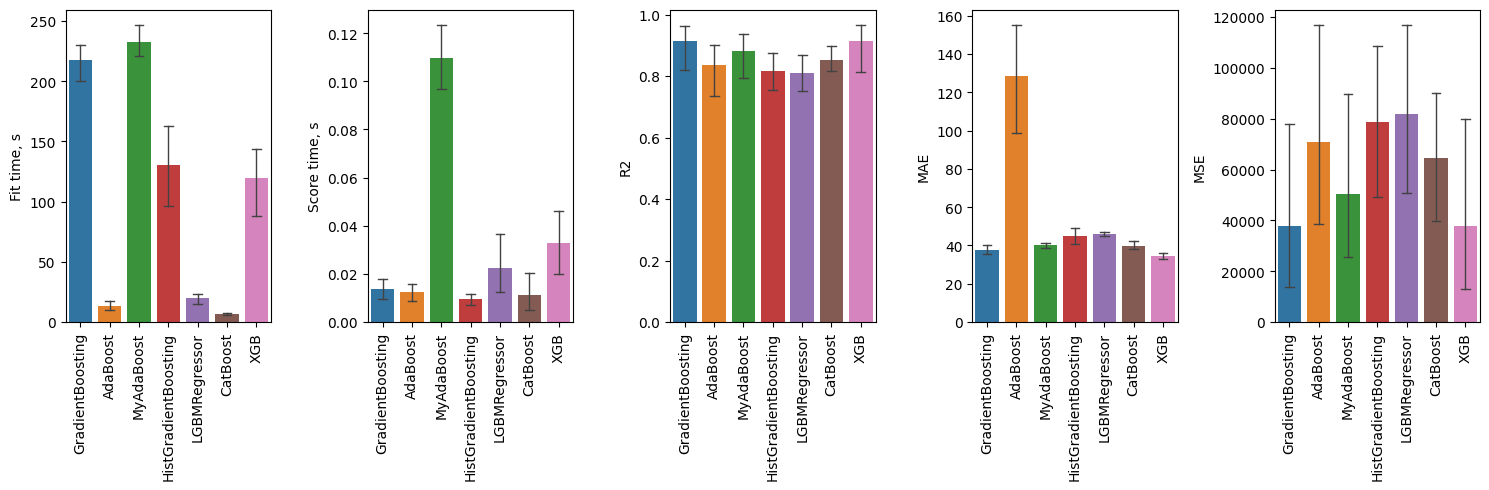

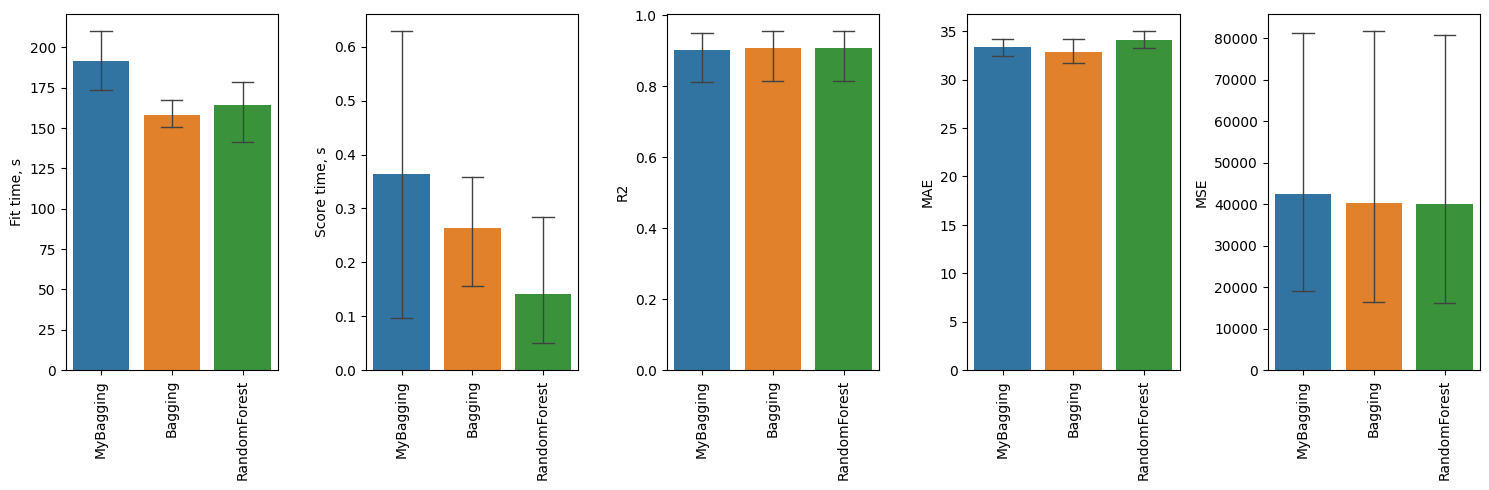

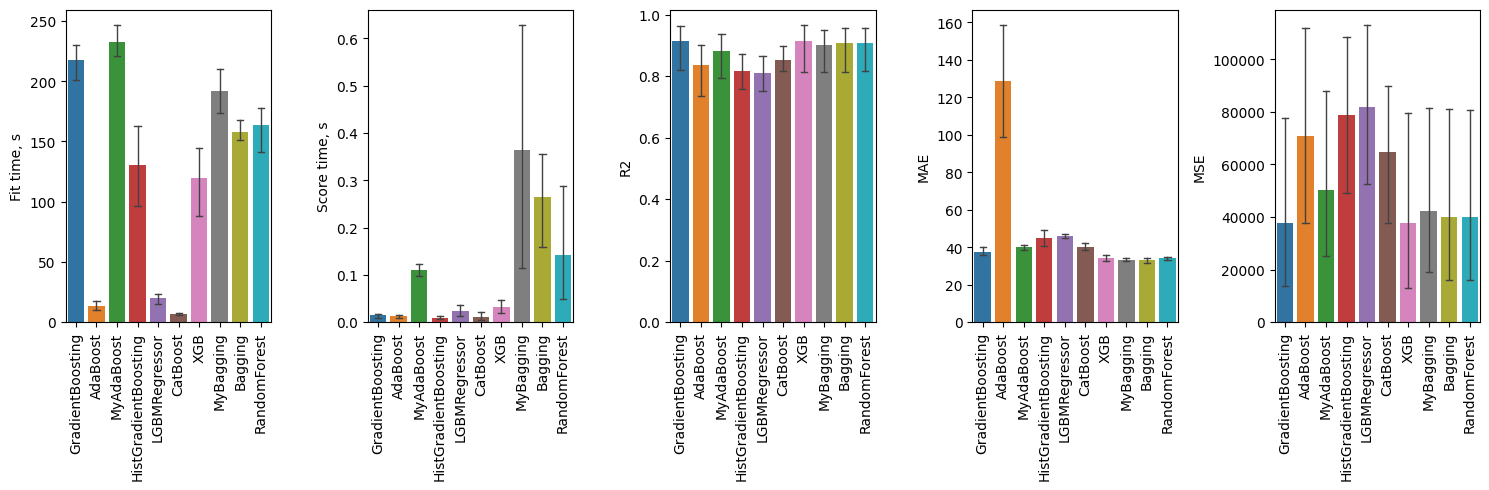

In [76]:
import pathlib

boosting_path = pathlib.Path("boosting.csv")
bagging_path = pathlib.Path("bagging.csv")
all_path = pathlib.Path("all.csv")

add_all_to_comparsion(boosting_models, pathlib.Path("boosting.csv"))
add_all_to_comparsion(bagging_models, pathlib.Path("bagging.csv"))
add_all_to_comparsion(boosting_models + bagging_models, pathlib.Path("all.csv"))

show_comparsion(boosting_path)
show_comparsion(bagging_path)
show_comparsion(all_path)